<h1 id="title"> Использование методов машинного обучения для решения задачи классификации текстов контрактов </h1>

Хохулин Алексей Витальевич ПМ21-3

---

<p>
<b>Цель курсовой работы</b>: исследовать возможности использования методов машинного обучения для решения задачи классификации текстов контрактов госзакупок по их цене.

<b>Описание проблемы</b>: \
Автоматизированная обработка и классификация протоколов о государственных закупках стали необходимостью для выявления подозрительных операций и других нарушений. Важно отметить, что государственные закупки являются важнейшим инструментом государственного управления экономикой, что делает их главной мишенью для коррупции и мошенничества. При классификации контрактов одним из ключевых параметров, который следует учитывать, является цена.

Чтобы свести к минимуму случаи мошенничества и коррупции в сфере государственных закупок, следует установить метод классификации договоров о закупках на основе их стоимости. В данной работе представлены метод чтений протоколов и распознания текста, анализ и подготовка данных, определение дизайна подходящей модели и обучение модели. В конечном счете, подход к классификации договоров о государственных закупках может быть оптимизирован с помощью полученных результатов.
</p>

# Разделы : <a class="anchor" id="0"></a>

* [1. Чтение протоколов](#1)

* [2. Препроцессинг текстов](#2)

* [3. Парсинг цен](#3)

* [4. Анализ собранных данных](#4)

* [5. Разделение данных на классы](#5)

* [6. Обучение](#6)

    * [6.1 Count Vectorizer](#6_1) 
    
    * [6.2 TF-IDF](#6_2) 
    
    * [6.3 Logistic Regression](#6_3) 
    
    * [6.4 Naive Bayes](#6_4) 
    
    * [6.5 SVM](#6_5) 
    
    * [6.6 Random Forest](#6_6) 
    
    * [6.7 XGBoost](#6_7) 
    
    * [6.8 CatBoost](#6_8) 
    
    * [6.9 RuBERT](#6_9)

* [7. Сравнение результатов и выбор лучших моделей](#7)

* [8. How to improve: Решение проблемы дизбаланса классов](#8)

* [9. Заключение](#9)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

<h2 id="1">1 <span style='color:#001B94'>|</span> Чтение протоколов</h2>

* [К оглавлению](#0)

<p class="comment" id="1"></p>

<p class="comment" id="1.1">Протоколы госудраственных закупок представлены в датасете в различных форматах: <i>pdf, docx, doc, jpg</i>. Также присутсвует несколько экземпляров в формате <i>xlsx</i>, которые не содержат текстовую информацию, они не подходят для этой работы. Перед чтением протоколов, все файлы формата <i>doc</i> конвертированы в <i>docx</i> с помощью соответсвующей утилиты <i>LibreOffice</i>, чтобы их можно было распознать.</p>
<p class="comment" id="1.2">Для чтения <i>docx</i> воспользуемся пакетом <b>textract</b>.</p>
<p class="comment" id="1.3">Для чтения <i>pdf</i> конвертируем каждую страницу в <i>jpeg</i> и, используя пакет <b>pytesseract</b> распознаем текст. Если документ содержит больше 3 страниц, пропускаем файл, чтобы не было большого дизбаланса длины текста.</p>
<p class="comment" id="1.4">Для распознавания текста с <i>jpg</i> также используем пакет <b>pytesseract</b>.</p>

In [2]:
import os
import pytesseract
import textract
import io
from PIL import Image
from wand.image import Image as wi

In [12]:
def read_doc_files(folder) -> list:
    '''
    Reads text from docx, pdf, jpg
    :return: list of tuples (filename, text)
    '''
    files = []
    exception_count = 0
    skip_count = 0
    for filename in tqdm(os.listdir(folder)):
        if filename.endswith(".docx") or filename.endswith(".DOCX"):
            try:
                text = textract.process(os.path.join(folder, filename), encoding='utf-8').decode('utf-8')
                files.append((filename, text))
            except:
                exception_count += 1
                pass

        if filename.endswith(".pdf") or filename.endswith(".PDF"):
            try:
                with wi(filename=os.path.join(folder, filename), resolution=220) as pdf_file:
                    image = pdf_file.convert('jpeg')
                image_blobs = []
                for img in image.sequence:
                    img_page = wi(image=img)
                    image_blobs.append(img_page.make_blob('jpeg'))
                text = []
                for img_blob in image_blobs:
                    im = Image.open(io.BytesIO(img_blob))
                    text.append(pytesseract.image_to_string(im, lang='rus'))
                files.append((filename, text))
            except:
                exception_count += 1
                pass

        if filename.endswith(".jpg") or filename.endswith(".JPG"):
            try:
                text = pytesseract.image_to_string(Image.open(os.path.join(folder, filename)), lang='rus')
                files.append((filename, text))
            except:
                exception_count += 1
                pass

        break
            
    print("Number of files read: ", len(files))
    print("Number of exceptions: ", exception_count)
    print("Number of skipped files: ", skip_count)
    return files

In [13]:
path = "./data/protocols/"
protocols = read_doc_files(path)

  0%|          | 0/2123 [01:08<?, ?it/s]

Number of files read:  1
Number of exceptions:  0
Number of skipped files:  0


100%|██████████| 2123/2123 [2:15:36<00:00,  3.83s/it] \
Number of files read:  2030 \
Number of exceptions:  2 \
Number of skipped files:  0

<p class="sub_comment" id="1.5">Удалось обработать парктически все файлы, за исключением 2 поврежденных документов. Сохраним полученные данные в <i>DataFrame</i>. Удалим протоколы, у которых не удалось распознать текст. Выделим реестровый номер извещения из названия файлов, чтобы впоследствии спарсить цены закупок.</p>

In [6]:
data = pd.DataFrame(protocols, columns=['filename', 'text'])

data = data[data['text'].map(len) > 0]
data = data[data['filename'].str.contains('_')]
data['id'] = data['filename'].apply(lambda x: x.split('_')[1])

data = data[['id', 'text']]
data['text'] = data['text'].apply(lambda x: " ".join(x) if type(x) == list else x)
data = data.dropna(subset=['text'])
data.to_csv("data_raw.csv", index=None)

<h2 id="2">2 <span style='color:#001B94'>|</span> Препроцессинг текстов</h2>

* [К оглавлению](#0)

<p class="comment" id="2"></p>

<p class="comment" id="2.1">Предварительная обработка текста — это процесс очистки и подготовки текстовых данных для дальнейшего анализа. Это важный шаг, поскольку он помогает повысить производительность моделей.</p>
<p class="comment" id="2.2">Для разбиения текста на слова и удаления знаков препинания, пробельных символов воспользуемся <i>RegexpTokenizer</i> из библиотеки <i>nltk</i>, также воспользуемся списком стоп слов из этой библиотеки.

Для удобства обернем все функции в единый класс <i>TextCleaning</i>.</p>

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[а-яА-Я]+')
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

In [ ]:
class TextCleaning:
    """
    Applies tokenizer
    Optionally you can use stemmer, lemmatizer, stop words
    """
    def __init__(self, tokenizer, stemmer=None, lemmatizer=None, stop_words=None):
        self._tokenizer = tokenizer
        self._stemmer = stemmer
        self._lemmatizer = lemmatizer
        self._stop_words = stop_words

    def _tokenize(self, input_string: list[str]) -> list[str]:
        return self._tokenizer.tokenize(input_string)
    
    def _stemm(self, input_string: list[str]) -> list[str]:
        return self._stemmer(input_string)

    def _lemmatize(self, input_string: list[str]) -> list[str]:
        return self._lemmatizer(input_string)
    
    def _stop(self, input_string: list[str]) -> list[str]:
        return [word for word in input_string if word not in self._stop_words]
    
    def _preprocess(
            self,
            input_string: list[str]
        ) -> str:
        if self._tokenizer:
            input_string = self._tokenize(input_string.lower())

        if self._stemmer:
            input_string = self._stemm(input_string)

        if self._lemmatizer:
            input_string = self._lemmatize(input_string)

        if self._stop_words:
            input_string = self._stop(input_string)

        input_string = [word for word in input_string if len(word) > 1]

        return " ".join(input_string)

    def preprocess(self, data:list[str]) -> list[str]:
        """
        Do all preprocessing
        :param data: List[str]
        :return: clean_data: List[List[str]]
        """
        return [self._preprocess(sample) for sample in data]

In [ ]:
text_cleaner = TextCleaning(tokenizer=tokenizer, stop_words=stop_words)

In [ ]:
data["text"] = text_cleaner.preprocess(data["text"])

In [ ]:
data.to_csv("data_preprocessed.csv", index=None)

In [ ]:
data = pd.read_csv("/kaggle/input/protocols-texts/data_with_price_text_preprocessed.csv")
data['text'] = data['text'].astype(str)
data['text']

0       утверждаю генеральный директор ооо компания во...
1       протокол заседания комиссии фгуп мба осуществл...
2       протокол осуществлении закупки единственного п...
3       утверждаю генеральный директор ооо компания во...
4       утверждаю генеральный директор ооо компания во...
                              ...                        
1878    протокол ишимбай января наименование закупки п...
1879    протокол рассмотрения оценки сопоставления зая...
1880    протокол закупки единственного поставщика испо...
1881    екатеринбургское муниципальное унитарное предп...
1882    поставка мя длинами допускается каждой катушке...
Name: text, Length: 1883, dtype: object

<p class="comment" id="2.3">Успешно предобработали текст, избавились от знаков препинания и других несмысловых символов, избавились от часто встречающихся слов, не несущих смысловую нагрузку и добавляющих шумы в данные.</p>

<h2 id="3">3 <span style='color:#001B94'>|</span> Парсинг цен</h2>

* [К оглавлению](#0)

<p class="comment" id="3"></p>

<p class="comment" id="3.1">Получим цены закупок, спарсив их с сайта <b>zakupki.kontur.ru</b>.</p>
<p class="comment" id="3.2">Так как некоторые цены указаны в долларах/евро, дополнительно реализуем функции, берущие актуальный курс валют для конвертации в рубли.</p>
<p class="comment" id="3.3">Для парсинга используем библиотеки <i>requests</i> и  <i>bs4</i>.</p>

In [7]:
import requests
import re
from bs4 import BeautifulSoup

In [8]:
def get_dollar_price():
    data = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()
    return float(data['Valute']['USD']['Value'])

def get_euro_price():
    data = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()
    return float(data['Valute']['EUR']['Value'])

In [9]:
def parse_price(id: str) -> int:
    """
    Parse price from zakupki.kontur.ru
    :param id: str
    :return: price: int
    """
    url = f"https://zakupki.kontur.ru/{id}"
    
    for i in range(40):
        response = requests.get(url)
        if response.status_code == 200:
            break

    else:
        return None
    
    soup = BeautifulSoup(response.text, 'html.parser')
    price_element = soup.find('div', {'class': 'tender-named-values_value'})
    
    if price_element is None:
        return None
    
    price_text = price_element.text.strip().split(',')[0]

    if not re.search(r'\d', price_text):
        return None

    price = int(re.sub(r'\D', '', price_text))
    
    if '$' in price_element.text:
        price *= get_dollar_price()
    elif '€' in price_element.text:
        price *= get_euro_price()
        
    return price

In [10]:
data = pd.read_csv('data.csv')

In [11]:
prices = []
for id in tqdm(data['id']):
    prices.append(parse_price(id))

data['price'] = prices

100%|██████████| 2023/2023 [04:49<00:00,  6.99it/s]


100%|██████████| 2023/2023 [04:48<00:00,  7.01it/s]

<p class="comment" id="3.4">Удалим протоколы с нулевой ценой, так как эти закупки не достигла стадии исполнения и цена не была определена.</p>

In [ ]:
data = data.dropna(subset=['price'])
data = data[data['price'] != 0]

In [ ]:
pd.isnull(data['price']).sum()

In [ ]:
data.to_csv("data_with_price.csv",index=None)

<p class="comment" id="3.5">Успешно получили данные цен, перейдем к анализу полученных данных.</p>

<h2 id="4">4 <span style='color:#001B94'>|</span> Анализ собранных данных</h2>

* [К оглавлению](#0)

<p class="comment" id="4"></p>

<p class="comment" id="4.1">Построим гистограмму распределения цен государственных закупок. Гистограмма показывает, сколько раз каждый диапазон цен встречается в данных.</p>
<p class="comment" id="4.2">Можно наблюдать, что большая закупок имеет цену меньше 1 миллиона, после 4 млн распредление приобретает равномерный характер.</p>

In [3]:
data = pd.read_csv("/kaggle/input/protocols-texts/data_with_price_text_preprocessed.csv")
data.text = data.text.astype(str)

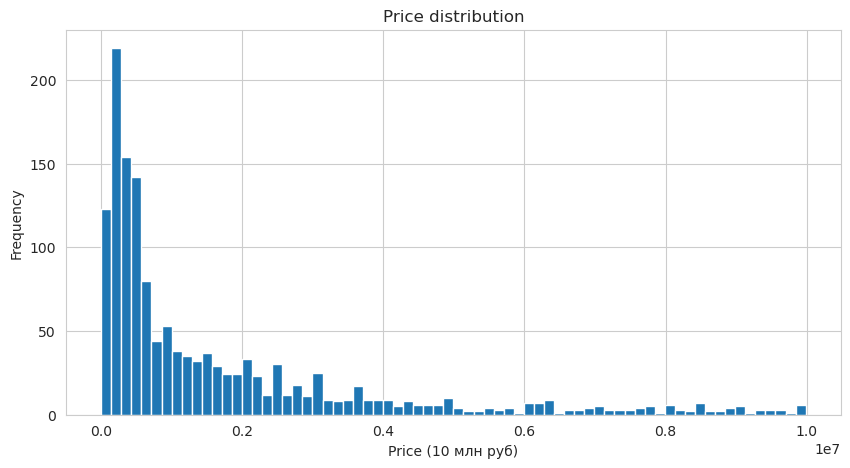

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(data['price'][data['price'] < 1 * 1e7], bins=70)
plt.title("Price distribution")
plt.xlabel("Price (10 млн руб)")
plt.ylabel("Frequency")
plt.show()

<p class="comment" id="4.3">Визуализируем облако слов. </p>

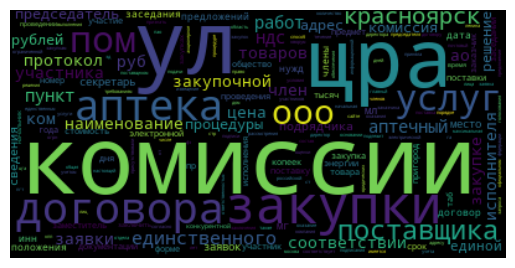

In [5]:
from collections import Counter
import wordcloud

word_counts = Counter()

for text in data['text']:
    words = text.split()
    word_counts.update(words)

wc = wordcloud.WordCloud()
wc.generate_from_frequencies(word_counts)
wc.to_image()

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<p class="sub_comment" id="4.4">Выведем самые часто встречающиеся слова.</p>

In [6]:
top_words = word_counts.most_common(20)
top_words

[('комиссии', 13099),
 ('ул', 10697),
 ('цра', 9516),
 ('закупки', 7497),
 ('договора', 6901),
 ('аптека', 6547),
 ('пом', 4969),
 ('услуг', 4557),
 ('ооо', 4399),
 ('поставщика', 4206),
 ('красноярск', 3813),
 ('единственного', 3805),
 ('работ', 3543),
 ('ндс', 3451),
 ('аптечный', 3378),
 ('пункт', 3314),
 ('протокол', 2973),
 ('наименование', 2788),
 ('заявки', 2785),
 ('участника', 2662)]

<p class="sub_comment" id="4.5">Cтоит обратить внимание на частоту встречаемости слов "аптека" и "аптечный" в списке самых часто встречающихся слов может указывать на то, что контракты, связанные с медицинскими товарами и услугами, составляют значительную долю в выборке текстов госзакупок.</p>

<h2 id="5">5 <span style='color:#001B94'>|</span> Разделение данных на классы</h2>

* [К оглавлению](#0)

<p class="comment" id="5"></p>

<p class="comment" id="5.1">
    Выделим классы закупок по цене:
    
* до 250 000 руб
* от 250 000 до 500 000 руб
* от 500 000 до 1 млн руб
* от 1 млн до 3 млн руб
* от 3 млн до 10 млн руб
* от 10 млн до 50 млн руб
* от 50 млн руб до 200 млн руб
* больше 200 млн руб
</p>

In [4]:
from sklearn.model_selection import train_test_split

def get_price_class(price):
    if price < 250000:
        return 0
    elif price < 500000:
        return 1
    elif price < 1000000:
        return 2
    elif price < 3000000:
        return 3
    elif price < 10000000:
        return 4
    elif price < 50000000:
        return 5
    elif price < 200000000:
        return 6
    else:
        return 7

data['price_class'] = data['price'].apply(get_price_class)

<p class="comment" id="5.2">Изобразим гистограмму распределения классов.</p>

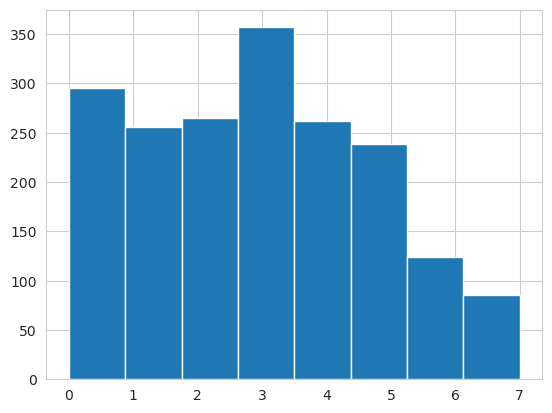

In [8]:
plt.hist(data['price_class'], bins=8)
plt.show()

<p class="comment" id="5.3">Распределение классов в выборке является дисбалансированным, что ожидаемо, учитывая, что количество контрактов с высокой ценой значительно меньше, чем с низкой ценой. </p> 

<p class="comment" id="5.4">Также разделим данные на выборки для <b>обучения</b>, которую модель использует, чтобы подобрать оптимальные параметры таким образом, чтобы минимизировать ошибку предсказания, <b>валидационную</b> выборку, которая используется для оценки производительности модели в процессе обучения и выбора лучшей модели и <b>тестовую</b> выборку, которая используется для окончательной оценки производительности модели, эта выборка содержит данные, которые не использовались ни в обучающей, ни в валидационной выборке.</p>

<p class="comment" id="5.5">Используем параметр <i>stratify</i>, чтобы получить стратифицированную выборку — это метод, обеспечивающий пропорциональное представление различных категорий в наборе данных в подмножестве данных. Это важно, когда модель обучается на несбалансированном наборе данных.</p>

In [6]:
X, y = data['text'], data['price_class']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42,  stratify=y_train_val)

<h2 id="6">6 <span style='color:#001B94'>|</span> Обучение</h2>

* [К оглавлению](#0)

<p class="comment" id="6">Перейдем к процессу обучения моделей.</p>

<p class="comment" id="6.1">Зададим функцию, вычисляющую различные метрики качества модели машинного обучения. Будем использовать следующие метрики:

- Метрика <b>accuracy</b> (точность) измеряет долю правильных ответов, то есть отношение числа правильно классифицированных объектов к общему числу объектов в выборке:

- Метрика <b>f1</b> (среднее гармоническое между <i>precision</i> и <i>recall</i>) учитывает несбалансированность классов и представляет собой среднее гармоническое между precision и recall по всем классам, где <i>precision</i> - точность, <i>recall</i> - полнота. Будем использовать <b>f1 macro</b>,     поскольку оно одинаково относится ко всем классам.

$$F1 = 2 \cdot  \frac{precision * recall}{precision + recall}$$

- Метрика <b>AUC-ROC</b> является мерой качества модели, учитывающей баланс между <i>true positive rate</i> (доля истинно положительных ответов) и <i>false positive rate</i> (доля ложно положительных ответов). <b>AUC-ROC</b> - площадь под кривой <i>ROC</i>, где <i>ROC</i>-кривая - это кривая, которая показывает зависимость <i>TPR</i> от <i>FPR</i> при изменении порога классификации.
</p>

<p class="comment" id="6.2">Также создадим таблицу, где будем хранить результаты моделей на валидационной выборке, чтобы впоследствии сравнить и выбрать лучшую модель.</p>

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder

def metrics_for_model(model, X_test, y_test, description=None, time=None):
    '''
    Calculates the metrics for a given model on a given test set.
    '''
    y_pred = model.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    ohe = OneHotEncoder()
    y_test_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()
    y_pred_ohe = ohe.transform(y_pred.reshape(-1, 1)).toarray()
    auc_score = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovr')
    print(f"F1-macro: {f1_macro}")
    print(f"ROC AUC: {auc_score}")
    print(f"Accuracy: {accuracy}")
    if description and description not in results_df['Description'].values:
        results_df.loc[len(results_df)] = [description, f1_macro, auc_score, accuracy, time]

In [24]:
results_df = pd.DataFrame(columns=['Description', 'F1-macro', 'ROC-AUC', 'Acc', 'time'])

<h2 id="6_1">6.1 <span style='color:#001B94'>|</span> Count Vectorizer</h2>

* [К оглавлению](#0)

<p class="comment" id="6_1"></p>

<p class="comment" id="6_1.1">Bag of Words (BoW) - это метод представления текстовых данных в виде коллекции (мешка) из отдельных слов без учета грамматики и порядка слов в тексте.

Суть метода заключается в том, что текст разбивается на отдельные слова, и каждое слово представляется как отдельный элемент в коллекции. Затем каждый документ представляется в виде вектора, где каждый элемент соответствует количеству вхождений соответствующего термина в документ.

Каждому слову присваивается уникальный номер. В пределах длины словарного запаса (словарь означает набор всех уникальных слов) назначается частота слов. Это кодирование слов, при котором мы фокусируемся на представлении слова, а не на порядке слова.
    
CountVectorizer - это метод Bag of Words. Он создает разреженные матрицы, где строки соответствуют документам, столбцы - словам, а значения в матрице указывают, сколько раз каждое слово встретилось в каждом документе.</p>


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train).toarray()

In [8]:
X_train_cv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<h2 id="6_2">6.2 <span style='color:#001B94'>|</span> TF-IDF</h2>

* [К оглавлению](#0)

<p class="comment" id="6_2"></p>

<p class="comment" id="6_2.1">TF-IDF или (Term Frequency (TF) — Inverse Dense Frequency (IDF)). Это метод, который помогает определить важность слов в тексте на основе их частотности и устраняет недостатки метода "мешок слов" (Bag of Words). Метод "мешок слов" подходит для классификации текста и превращает слова в числа, но не способен понимать смысл предложений или документов.

С помощью TF-IDF можно определить важность слова в контексте всего документа, учитывая и частотность встречаемости слова в документе (TF), и частотность встречаемости слова во всей коллекции документов (IDF). Это позволяет выделить ключевые слова и фразы, которые наиболее характерны для данного текста и могут помочь понять его содержание.<p>

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_transformer = TfidfVectorizer()

X_train_TFIDF = text_transformer.fit_transform(X_train).toarray()

In [10]:
X_train_TFIDF

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01960219, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<h2 id="6_3">6.3 <span style='color:#001B94'>|</span> Logistic Regression</h2>

* [К оглавлению](#0)

<p class="comment" id="6_3"></p>

<p class="comment" id="6_3.1"><b>Логистическая регрессия</b> — это простая модель машинного обучения, она работает, оценивая вероятность того, что входные данные принадлежат определенному классу. Это достигается путем изучения набора весов для каждой функции во входных данных и объединения этих весов со значениями функций для вычисления линейной комбинации. Эта линейная комбинация затем передается через сигмовидную функцию, которая отображает выходное значение в диапазоне от 0 до 1. Результирующее значение представляет собой прогнозируемую вероятность того, что входные данные принадлежат положительному классу. </p>

<p class="comment" id="6_3.2"> Для начала попробуем использовать логистическую регрессию в связке с <i>CountVectoizer</i>. </p>

In [176]:
from sklearn.linear_model import LogisticRegression

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train).toarray()
X_val_cv = cv.transform(X_val).toarray()

logreg = LogisticRegression(random_state=42, n_jobs=-1)

In [26]:
%%time
logreg.fit(X_train_cv, y_train)

CPU times: user 102 ms, sys: 139 ms, total: 241 ms
Wall time: 12.7 s


LogisticRegression(n_jobs=-1, random_state=42)

In [27]:
metrics_for_model(logreg, X_val_cv, y_val, 'def CV + LogReg', '12.7 s')

F1-macro: 0.4674266052336228
ROC AUC: 0.6871674547211186
Accuracy: 0.4768211920529801


<p class="comment" id="6_3.3"> 
После построения простой модели, с помощью Pipeline и GridSearchCV (Grid Search Cross-Validation) подберем наилучшие гиперпараметры модели. Будем использовать StratifiedKFold — это метод перекрестной проверки, который гарантирует, что каждая часть перекрестной проверки имеет то же распределение классов, что и исходный набор данных. Предварительно создадим словарь с возможными значениями параметров:

- max_df — это параметр <i>CountVectorizer</i>, который управляет максимальной частотой документа термина. Это означает, что любой термин, который встречается в более чем указанном проценте документов, будет игнорироваться.
- min_df — это параметр <i>CountVectorizer</i>, который управляет минимальной частотой документа для термина. Это означает, что любой термин, который встречается в меньшем, чем указанный процент документов, будет игнорироваться.
- ngram_range — это параметр <i>CountVectorizer</i>, который указывает минимальную и максимальную длину n-грамм, которые следует учитывать. N-грамма — это последовательность из n слов. 
- C — это гиперпараметр <i>LogisticRegression</i>, контролирующий силу регуляризации. Регуляризация — это метод, помогающий предотвратить переоснащение, которое может возникнуть при обучении модели на небольшом наборе данных.
</p>

In [177]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf_cv_logreg = Pipeline([
    ('cv', CountVectorizer()),
    ('logreg', LogisticRegression(random_state=42, n_jobs=-1)),
])

hyperparameters = {
    'cv__max_df':[0.8, 1.0],
    'cv__min_df': [1, 2],
    'cv__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.01, 0.1, 1.0, 10],
    'logreg__solver': ['newton-cg'],
}

grid_search_tune = GridSearchCV(
    clf_cv_logreg, 
    hyperparameters,
    cv=skf, 
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
)

<p class="comment" id="6_3.3"> Подберем гиперпараметры на всей выборке кроме тестовой. </p>

In [39]:
%%time
grid_search_tune.fit(X_train_val, y_train_val)

print(f'Best Hyperparameters: {grid_search_tune.best_params_}')
print(f'Best F1(macro): {grid_search_tune.best_score_:.2f}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'cv__max_df': 0.8, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'logreg__C': 1.0, 'logreg__solver': 'newton-cg'}
Best F1(macro): 0.51
CPU times: user 3.43 s, sys: 2.37 s, total: 5.8 s
Wall time: 39min 28s


<p class="comment" id="6_3.4"> Создаем модель с лучшими гиперпараметрами.</p>

In [34]:
cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)

logreg_best_params = LogisticRegression(
    C=1,
    solver='newton-cg',
    random_state=42, 
    n_jobs=-1,
)

X_train_cv = cv_best_params.fit_transform(X_train).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()

In [35]:
%%time
logreg_best_params.fit(X_train_cv, y_train)

CPU times: user 210 ms, sys: 389 ms, total: 598 ms
Wall time: 2min 21s


LogisticRegression(C=1, n_jobs=-1, random_state=42, solver='newton-cg')

In [36]:
metrics_for_model(logreg_best_params, X_val_cv, y_val, 'CV + LogReg', '2min 21s')

F1-macro: 0.4738284810483734
ROC AUC: 0.6944481111510656
Accuracy: 0.49337748344370863


---
<p class="comment" id="6_3.5"> Теперь попробуем логистическую регрессию в связке с <i>TF-IDF</i>. </p>

In [38]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_val_tfidf = tfidf.transform(X_val).toarray()

logreg = LogisticRegression(random_state=42, n_jobs=-1)

In [39]:
%%time
logreg.fit(X_train_tfidf, y_train)

CPU times: user 71.3 ms, sys: 97.4 ms, total: 169 ms
Wall time: 7.07 s


LogisticRegression(n_jobs=-1, random_state=42)

In [40]:
metrics_for_model(logreg, X_val_tfidf, y_val, 'def TF-IDF + LogReg', '7.07 s')

F1-macro: 0.47290110715085754
ROC AUC: 0.6866953443493202
Accuracy: 0.47019867549668876


<p class="comment" id="6_3.6">Теперь так же подберем гиперпараметры с помощью <i>GridSearchCV</i>.</p>

In [15]:
clf_tfidf_logreg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state=42, n_jobs=-1)),
])

hyperparameters = {
    'tfidf__max_df': [0.7, 0.8, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1.0, 10],
    'logreg__solver': ['newton-cg'],
}

grid_search_tune = GridSearchCV(
    clf_tfidf_logreg, 
    hyperparameters,
    cv=skf, 
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
)

In [46]:
%%time
grid_search_tune.fit(X_train_val, y_train_val)

print(f'Best Hyperparameters: {grid_search_tune.best_params_}')
print(f'Best F1-macro: {grid_search_tune.best_score_:.2f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'logreg__C': 10, 'logreg__solver': 'newton-cg', 'tfidf__max_df': 0.7, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best F1-macro: 0.49
CPU times: user 3.52 s, sys: 506 ms, total: 4.02 s
Wall time: 6min 33s


<p class="comment" id="6_3.6"> Создаем модель с лучшими гиперпараметрами. </p>

In [42]:
tfidf_best_params = TfidfVectorizer(
    max_df=0.7,
    ngram_range=(1, 2)
)

logreg_best_params = LogisticRegression(
    C=10,
    random_state=42, 
    n_jobs=-1,
    solver='newton-cg'
)

X_train_TFIDF = tfidf_best_params.fit_transform(X_train).toarray()
X_val_TFIDF = tfidf_best_params.transform(X_val).toarray()

In [43]:
%%time
logreg_best_params.fit(X_train_TFIDF, y_train)

CPU times: user 387 ms, sys: 568 ms, total: 954 ms
Wall time: 1min 5s


LogisticRegression(C=10, n_jobs=-1, random_state=42, solver='newton-cg')

In [44]:
metrics_for_model(logreg_best_params, X_val_TFIDF, y_val, 'TF-IDF + LogReg', '1min 5s')

F1-macro: 0.47879760932756327
ROC AUC: 0.6950404596025083
Accuracy: 0.4900662251655629


<h2 id="6_4">6.4 <span style='color:#001B94'>|</span> Naive Bayes</h2>

* [К оглавлению](#0)

<p class="comment" id="6_4"></p>

<p class="comment" id="6_4.1"><b>Naive Bayes</b> - это простой и эффективный алгоритм машинного обучения для задач классификации и прогнозирования. Он основан на теореме Байеса, которая позволяет вычислить вероятность того, что объект принадлежит к определенному классу, на основе его признаков.

Наивный Байес считается "наивным", потому что он предполагает, что все признаки независимы друг от друга, что в реальности часто не соответствует действительности. Тем не менее, на практике этот алгоритм работает хорошо и может давать высокое качество классификации в различных задачах.
</p>

<p class="comment" id="6_4.2">Также попробуем использовать его в связке с <i>Count Vectorizer</i> и <i>TF-IDF</i>, подобрав гиперпараметры.</p>

In [49]:
from sklearn.naive_bayes import GaussianNB

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train).toarray()
X_val_cv = cv.transform(X_val).toarray()

nb = GaussianNB()

In [51]:
%%time
nb.fit(X_train_cv, y_train)

CPU times: user 304 ms, sys: 114 ms, total: 418 ms
Wall time: 417 ms


GaussianNB()

In [52]:
metrics_for_model(nb, X_val_cv, y_val, 'def CV + NB', '0.4s')

F1-macro: 0.42584665436329283
ROC AUC: 0.6671659423781602
Accuracy: 0.4205298013245033


<p class="comment" id="6_4.3">
    Подберем <i>var_smoothing</i> — это гиперпараметр, который управляет степенью сглаживания, применяемой к дисперсии гауссовых распределений. Сглаживание помогает предотвратить переобучение, делая модель менее чувствительной к небольшим изменениям данных.</p>

In [57]:
cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)

X_train_val_cv = cv_best_params.fit_transform(X_train_val).toarray()

hyperparameters = {
    'var_smoothing': [1e-11, 1e-10, 1e-9]
}

grid_search_tune = GridSearchCV(
    GaussianNB(), 
    hyperparameters,
    cv=skf, 
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
)

In [58]:
%%time
grid_search_tune.fit(X_train_val_cv, y_train_val)

print(f'Best Hyperparameters: {grid_search_tune.best_params_}')
print(f'Best F1-macro: {grid_search_tune.best_score_:.2f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameters: {'var_smoothing': 1e-10}
Best F1-macro: 0.48
CPU times: user 1.01 s, sys: 779 ms, total: 1.79 s
Wall time: 29.7 s


<p class="comment" id="6_4.4"> Создаем модель с лучшими гиперпараметрами. </p>

In [59]:
nb_best_params = GaussianNB(var_smoothing=1e-10)

X_train_cv = cv_best_params.fit_transform(X_train).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()

In [61]:
%%time
nb_best_params.fit(X_train_cv, y_train)

CPU times: user 493 ms, sys: 214 ms, total: 707 ms
Wall time: 707 ms


GaussianNB(var_smoothing=1e-10)

In [62]:
metrics_for_model(nb_best_params, X_val_cv, y_val, 'CV + NB', '0.7s')

F1-macro: 0.4269306396672815
ROC AUC: 0.6627542679589533
Accuracy: 0.423841059602649


---
<p class="comment" id="6_4.5"> Теперь попробуем Naive Bayes в связке с <i>TF-IDF</i>. </p>

In [73]:
X_train_tfidf = tfidf_best_params.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_best_params.transform(X_val).toarray()

nb = GaussianNB()

In [65]:
%%time
nb.fit(X_train_tfidf, y_train)

CPU times: user 243 ms, sys: 84.5 ms, total: 327 ms
Wall time: 331 ms


GaussianNB()

In [72]:
metrics_for_model(nb, X_val_tfidf, y_val, 'def TF-IDF + NB', '0.3s')

F1-macro: 0.4094956822754213
ROC AUC: 0.6600855928266216
Accuracy: 0.40397350993377484


<p class="comment" id="6_4.6">Применим подбор гиперпараметров.</p>

In [75]:
tfidf_best_params = TfidfVectorizer(
    max_df=0.7,
    ngram_range=(1, 2)
)

X_train_val_tfidf = tfidf_best_params.fit_transform(X_train_val).toarray()

hyperparameters = {
    'var_smoothing': [1e-11, 1e-10, 1e-9]
}

grid_search_tune = GridSearchCV(
    GaussianNB(), 
    hyperparameters,
    cv=skf, 
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
)

In [76]:
%%time
grid_search_tune.fit(X_train_val_tfidf, y_train_val)

print(f'Best Hyperparameters: {grid_search_tune.best_params_}')
print(f'Best F1-macro: {grid_search_tune.best_score_:.2f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameters: {'var_smoothing': 1e-11}
Best F1-macro: 0.47
CPU times: user 2.43 s, sys: 2 s, total: 4.43 s
Wall time: 1min 14s


In [77]:
tfidf_best_params = TfidfVectorizer(
    max_df=0.7,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_best_params.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_best_params.transform(X_val).toarray()

nb_best_params = GaussianNB(var_smoothing=1e-11)

In [79]:
%%time
nb_best_params.fit(X_train_tfidf, y_train)

CPU times: user 1.28 s, sys: 601 ms, total: 1.88 s
Wall time: 1.89 s


GaussianNB(var_smoothing=1e-11)

In [80]:
metrics_for_model(nb_best_params, X_val_tfidf, y_val, 'TF-IDF + NB', '1.89s')

F1-macro: 0.43291626398174843
ROC AUC: 0.6685791244657942
Accuracy: 0.4337748344370861


In [82]:
results_df

,Description,F1-macro,ROC-AUC,Acc,time
0,def CV + LogReg,0.467427,0.687167,0.476821,12.7 s
1,CV + LogReg,0.473828,0.694448,0.493377,2min 21s
2,def TF-IDF + LogReg,0.472901,0.686695,0.470199,7.07 s
3,TF-IDF + LogReg,0.478798,0.695040,0.490066,1min 5s
4,def CV + NB,0.425847,0.667166,0.420530,0.4s
5,CV + NB,0.426931,0.662754,0.423841,0.7s
6,def TF-IDF + NB,0.409496,0.660086,0.403974,0.3s
7,TF-IDF + NB,0.432916,0.668579,0.433775,1.89s


<p class="comment" id="6_4.7">Naive Bayes показал результат хуже, чем логистическая регрессия, но ее обучения заняло гораздно меньше времени, это говорит об простоте модели и ограничности ее применения.
</p>

<h2 id="6_5">6.5 <span style='color:#001B94'>|</span> SVM</h2>

* [К оглавлению](#0)

<p class="comment" id="6_5"></p>


<p class="comment" id="6_5.1"><b>SVM</b> (Support Vector Machines, Метод опорных векторов) - это алгоритм машинного обучения. Он основан на идее поиска гиперплоскости в многомерном пространстве, которая максимально разделяет объекты разных классов. В процессе обучения SVM строит оптимальную гиперплоскость, которая максимизирует расстояние между разделяющей гиперплоскостью и ближайшими объектами каждого класса. Такие объекты называются опорными векторами. Они определяют положение гиперплоскости и используются для построения классификатора. </p>

<p class="comment" id="6_5.2">
В SVM используется ядерный метод, который позволяет перевести данные в пространство более высокой размерности, где они могут быть разделены линейно. Ядерная функция вычисляет скалярное произведение между векторами признаков в новом пространстве. Одним из преимуществ ядерного метода является возможность работать с данными, которые не могут быть разделены линейно в исходном пространстве.
С помощью <i>GridSearchCV</i> подберем лучшие гиперпараметры, в том числе ядерную функцию.

Существует несколько видов ядерных функций, которые могут быть использованы в SVM, включая:

- Линейное ядро - это самый простой вид ядра, который используется для линейной классификации. Оно вычисляет скалярное произведение между векторами признаков в исходном пространстве.

- Полиномиальное ядро - это ядро, которое позволяет работать с нелинейными данными, в которых есть нелинейные взаимодействия между признаками. Оно вычисляет скалярное произведение между векторами признаков в пространстве более высокой размерности, которое получается путем возведения в степень исходного пространства.

- RBF (Radial Basis Function) - вид ядра, который часто используется для нелинейной классификации. Оно преобразует данные в бесконечно-мерное пространство, где объекты могут быть легко разделены. RBF ядро имеет параметр gamma, который регулирует форму ядра и влияет на точность модели.

- Sigmoid ядро. Оно преобразует данные в пространство более высокой размерности, где объекты могут быть разделены с помощью гиперболического тангенса.</p>

<p class="comment" id="6_5.3">Также попробуем использовать эту модель в связке с <i>Count Vectorizer</i> и <i>TF-IDF</i>, подобрав гиперпараметры.</p>

In [84]:
from sklearn.svm import SVC

clf_cv_svc = Pipeline([
    ('cv', CountVectorizer()),
    ('svc', SVC(random_state=42)),
])

hyperparameters = {
    'cv__max_df':[0.8, 1.0],
    'cv__min_df': [1, 2],
    'cv__ngram_range': [(1, 1), (1, 2)],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_search_tune = GridSearchCV(
    clf_cv_svc, 
    hyperparameters,
    cv=skf, 
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
)

In [86]:
%%time
grid_search_tune.fit(X_train_val, y_train_val)

print(f'Best Hyperparameters: {grid_search_tune.best_params_}')
print(f'Best F1-macro: {grid_search_tune.best_score_:.2f}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'cv__max_df': 0.8, 'cv__min_df': 1, 'cv__ngram_range': (1, 1), 'svc__C': 0.1, 'svc__kernel': 'linear'}
Best F1-macro: 0.49
CPU times: user 10.9 s, sys: 1.53 s, total: 12.5 s
Wall time: 31min 5s


<p class="comment" id="6_5.4"> Создаем модель с лучшими гиперпараметрами. </p>

In [87]:
svc_best_params = SVC(random_state=42, C=0.1, kernel='linear')

cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=1,
    ngram_range=(1,1)
)

X_train_cv = cv_best_params.fit_transform(X_train).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()

In [89]:
%%time
svc_best_params.fit(X_train_cv, y_train)

CPU times: user 46.8 s, sys: 8.82 s, total: 55.6 s
Wall time: 29.1 s


SVC(C=0.1, kernel='linear', random_state=42)

In [91]:
metrics_for_model(svc_best_params, X_val_cv, y_val, 'CV + SVC', '29.1s')

F1-macro: 0.4602677638482912
ROC AUC: 0.6883992703986286
Accuracy: 0.48013245033112584


---
<p class="comment" id="6_5.6"> Теперь попробуем в связке с <i>TF-IDF</i>. </p>

In [93]:
clf_tfidf_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(random_state=42)),
])

hyperparameters = {
    'tfidf__max_df': [0.7, 0.8, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_search_tune = GridSearchCV(
    clf_tfidf_svc, 
    hyperparameters,
    cv=skf, 
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
)

In [94]:
%%time
grid_search_tune.fit(X_train_val, y_train_val)

print(f'Best Hyperparameters: {grid_search_tune.best_params_}')
print(f'Best F1-macro: {grid_search_tune.best_score_:.2f}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'svc__C': 10, 'svc__kernel': 'sigmoid', 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best F1-macro: 0.49
CPU times: user 18.3 s, sys: 1.9 s, total: 20.2 s
Wall time: 49min 25s


In [95]:
tfidf_best_params = TfidfVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_best_params.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_best_params.transform(X_val).toarray()

svc_best_params = SVC(C=10, kernel='sigmoid', random_state=42)

In [96]:
%%time
svc_best_params.fit(X_train_tfidf, y_train)

CPU times: user 1min 25s, sys: 11.8 s, total: 1min 37s
Wall time: 50.5 s


SVC(C=10, kernel='sigmoid', random_state=42)

In [97]:
metrics_for_model(svc_best_params, X_val_tfidf, y_val, 'TF-IDF + SVC', '50s')

F1-macro: 0.4637827314887263
ROC AUC: 0.68893413486556
Accuracy: 0.4768211920529801


<h2 id="6_6">6.6 <span style='color:#001B94'>|</span> Random Forest</h2>

* [К оглавлению](#0)

<p class="comment" id="6_6"></p>

<p class="comment" id="6_6.1">
    <b>Random Forest</b> - это алгоритм машинного обучения, который используется для классификации, регрессии и других задач, основанных на анализе данных. Он представляет собой ансамбль деревьев решений, где каждое дерево строится независимо друг от друга на случайной подвыборке данных.</p>
    
<p class="comment" id="6_6.2">Также подберем гиперпараметры с помощью <i>GridSearchCV</i>:

- n_estimators — количество деревьев в случайном лесу.
- max_depth — максимальная глубина каждого дерева в случайном лесу. Более глубокое дерево может изучить более сложные закономерности в данных.
- min_samples_split — это минимальное количество выборок, необходимое для разделения узла в дереве. Более высокое значение min_samples_split предотвратит слишком много разбиений дерева, что может помочь предотвратить переоснащение.
- min_samples_leaf — это минимальное количество выборок, которое должно находиться на листовом узле дерева. Более высокое значение min_samples_leaf не позволит дереву создавать слишком много маленьких листьев, что также может помочь предотвратить переоснащение.
    
Попробуем использовать эту модель в связке с <i>Count Vectorizer</i> и <i>TF-IDF</i>, подобрав гиперпараметры.
</p>

In [153]:
from sklearn.ensemble import RandomForestClassifier

clf_cv_rfc = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier()),
])

hyperparameters = {
    'cv__max_df':[0.8, 1.0],
    'cv__min_df': [1, 2], 
    'cv__ngram_range': [(1, 1), (1, 2)],
    'rfc__n_estimators': [50, 100, 200, 300],
    'rfc__max_depth': [5, 10, 15, 20],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
}

grid_search_tune = GridSearchCV(
    clf_cv_rfc, 
    hyperparameters,
    cv=skf, 
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
)

In [101]:
%%time
grid_search_tune.fit(X_train_val, y_train_val)

print(f'Best Hyperparameters: {grid_search_tune.best_params_}')
print(f'Best F1 macro: {grid_search_tune.best_score_:.2f}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'cv__max_df': 0.8, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'rfc__max_depth': 20, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 200}
Best F1 macro: 0.50
CPU times: user 12.1 s, sys: 2.01 s, total: 14.1 s
Wall time: 17min 31s


<p class="comment" id="6_6.3">Создаем модель с лучшими гиперпараметрами.</p>

In [154]:
cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)
X_train_cv = cv_best_params.fit_transform(X_train).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()

rfc_best_params = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=1
)

In [103]:
%%time
rfc_best_params.fit(X_train_cv, y_train)

CPU times: user 6.57 s, sys: 71 ms, total: 6.64 s
Wall time: 6.64 s


RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200)

In [106]:
metrics_for_model(rfc_best_params, X_val_cv, y_val, 'CV + RF', '6.64s')

F1-macro: 0.4787947055048085
ROC AUC: 0.6916272610888096
Accuracy: 0.4966887417218543


---
<p class="comment" id="6_6.4"> Теперь попробуем в связке с <i>TF-IDF</i>. </p>

In [108]:
clf_tfidf_rfc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier()),
])

hyperparameters = {
    'tfidf__max_df': [0.7, 0.8, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'rfc__n_estimators': [50, 100, 200, 300],
    'rfc__max_depth': [5, 10, 15, 20],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
}

grid_search_tune = GridSearchCV(
    clf_tfidf_rfc, 
    hyperparameters,
    cv=skf, 
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
)

In [109]:
%%time
grid_search_tune.fit(X_train_val, y_train_val)

print(f'Best Hyperparameters: {grid_search_tune.best_params_}')
print(f'Best F1 macro: {grid_search_tune.best_score_:.2f}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'rfc__max_depth': 20, 'rfc__min_samples_leaf': 2, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 200, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best F1 macro: 0.47
CPU times: user 12.4 s, sys: 1.82 s, total: 14.2 s
Wall time: 18min 26s


In [110]:
tfidf_best_params = TfidfVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_best_params.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_best_params.transform(X_val).toarray()

rfc_best_params = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2
)

In [111]:
%%time
rfc_best_params.fit(X_train_tfidf, y_train)

CPU times: user 6.8 s, sys: 59.2 ms, total: 6.86 s
Wall time: 6.88 s


RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=200)

In [112]:
metrics_for_model(rfc_best_params, X_val_tfidf, y_val, 'TF-IDF + RF', '6.88s')

F1-macro: 0.48009238988212444
ROC AUC: 0.6909930350765443
Accuracy: 0.4966887417218543


<h2 id="6_7">6.7 <span style='color:#001B94'>|</span> XGBoost</h2>

* [К оглавлению](#0)

<p class="comment" id="6_7"></p>

<p class="comment" id="6_7.1">
<b>XGBoost</b> (Extreme Gradient Boosting) - это алгоритм машинного обучения, используемый для задач классификации, регрессии и ранжирования. Он основан на методе градиентного бустинга, который позволяет построить ансамбль слабых моделей (например, деревьев решений), обученных последовательно на остатках предыдущей модели. XGBoost - это более быстрая и точная реализация градиентного бустинга, которая использует особенности как алгоритмов градиентного спуска, так и деревьев решений.
</p>

<p class="comment" id="6_7.2">
Основные преимущества XGBoost:

- Высокая точность: XGBoost может давать лучшие результаты, чем другие алгоритмы машинного обучения, особенно в задачах классификации и регрессии.

- Быстродействие: XGBoost может обрабатывать большие объемы данных быстрее, чем другие алгоритмы машинного обучения, такие как Random Forest или Gradient Boosting.

- Регуляризация: XGBoost предоставляет несколько методов регуляризации, которые позволяют предотвратить переобучение модели.

- Встроенная поддержка параллельных вычислений: XGBoost может использовать все ядра процессора и работать на GPU.
</p>

<p class="comment" id="6_7.3">Построим модель в связке с <i>CountVectorizer</i>.</p>

In [272]:
import xgboost as xgb

In [274]:
xgb_cl_cv = xgb.XGBClassifier(
    tree_method='gpu_hist',
    n_estimators=300,
    random_state=42
)

In [275]:
X_train_cv = cv_best_params.fit_transform(X_train).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()

<p class="comment" id="6_7.3">Используем параметры <i>eval_set</i> и <i>early_stopping_rounds</i> для предотвращения переобучения в XGBoost. Метод работает, останавливая процесс обучения досрочно, если потеря проверки не улучшается в течение определенного количества раундов. Это гарантирует, что модель не подходит к обучающим данным и хорошо обобщается на новые данные.</p>

In [276]:
%%time
xgb_cl_cv.fit(
    X_train_cv,
    y_train,
    eval_set=[(X_train_cv, y_train), (X_val_cv, y_val)],
    early_stopping_rounds=10,
    eval_metric=['mlogloss','auc'],
    verbose=True
)

[0]	validation_0-mlogloss:1.69080	validation_0-auc:0.89785	validation_1-mlogloss:1.80083	validation_1-auc:0.79927
[1]	validation_0-mlogloss:1.43848	validation_0-auc:0.94076	validation_1-mlogloss:1.63793	validation_1-auc:0.83484
[2]	validation_0-mlogloss:1.26369	validation_0-auc:0.95913	validation_1-mlogloss:1.52818	validation_1-auc:0.84977
[3]	validation_0-mlogloss:1.12962	validation_0-auc:0.96913	validation_1-mlogloss:1.45865	validation_1-auc:0.85455
[4]	validation_0-mlogloss:1.02177	validation_0-auc:0.97553	validation_1-mlogloss:1.41518	validation_1-auc:0.85715
[5]	validation_0-mlogloss:0.92487	validation_0-auc:0.98114	validation_1-mlogloss:1.37191	validation_1-auc:0.86142
[6]	validation_0-mlogloss:0.85340	validation_0-auc:0.98441	validation_1-mlogloss:1.34290	validation_1-auc:0.86268
[7]	validation_0-mlogloss:0.78705	validation_0-auc:0.98780	validation_1-mlogloss:1.32117	validation_1-auc:0.86654
[8]	validation_0-mlogloss:0.73165	validation_0-auc:0.99029	validation_1-mlogloss:1.30261

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

<p class="comment" id="6_7.4">Изобразим графики изменения ошибки и <i>ROC-AUC</i> на обучающей и валидационных выборках в процессе обучения.</p> 

In [277]:
results = xgb_cl_cv.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

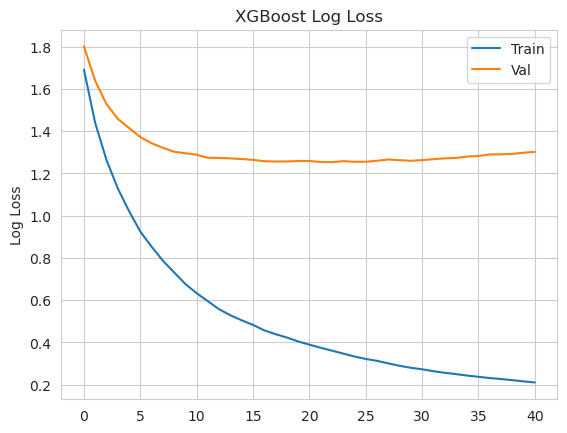

In [278]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

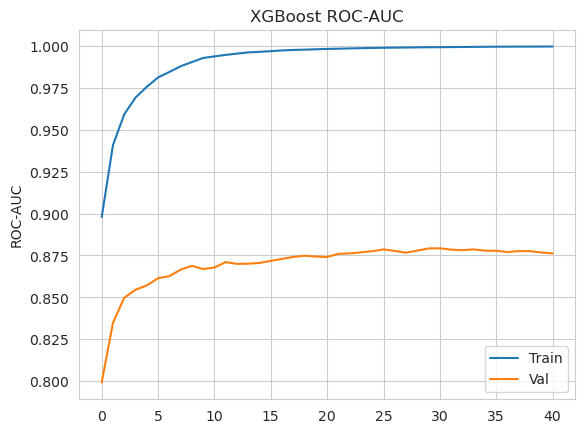

In [279]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Val')
ax.legend()
plt.ylabel('ROC-AUC')
plt.title('XGBoost ROC-AUC')
plt.show()

In [280]:
metrics_for_model(xgb_cl_cv, X_val_cv, y_val, 'CV + XGB', '1min 13s (GPU)')

F1-macro: 0.5680067959842646
ROC AUC: 0.7490105636161204
Accuracy: 0.5960264900662252


---
<p class="comment" id="6_7.5"> Теперь попробуем в связке с <i>TF-IDF</i>. </p>

In [160]:
X_train_tfidf = tfidf_best_params.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_best_params.transform(X_val).toarray()

In [161]:
%%time
xgb_cl.fit(
    X_train_tfidf,
    y_train,
    eval_set=[(X_train_tfidf, y_train), (X_val_tfidf, y_val)],
    early_stopping_rounds=5,
    eval_metric=['mlogloss','auc'],
    verbose=True
)

[0]	validation_0-mlogloss:1.67005	validation_0-auc:0.90339	validation_1-mlogloss:1.81585	validation_1-auc:0.76603
[1]	validation_0-mlogloss:1.39554	validation_0-auc:0.94954	validation_1-mlogloss:1.66416	validation_1-auc:0.81088
[2]	validation_0-mlogloss:1.20299	validation_0-auc:0.96897	validation_1-mlogloss:1.56897	validation_1-auc:0.83051
[3]	validation_0-mlogloss:1.05606	validation_0-auc:0.97771	validation_1-mlogloss:1.50669	validation_1-auc:0.83335
[4]	validation_0-mlogloss:0.93900	validation_0-auc:0.98387	validation_1-mlogloss:1.45180	validation_1-auc:0.84305
[5]	validation_0-mlogloss:0.83769	validation_0-auc:0.98865	validation_1-mlogloss:1.40391	validation_1-auc:0.84924
[6]	validation_0-mlogloss:0.75670	validation_0-auc:0.99141	validation_1-mlogloss:1.37409	validation_1-auc:0.85251
[7]	validation_0-mlogloss:0.69324	validation_0-auc:0.99367	validation_1-mlogloss:1.35518	validation_1-auc:0.85652
[8]	validation_0-mlogloss:0.63901	validation_0-auc:0.99493	validation_1-mlogloss:1.34465

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

<p class="comment" id="6_7.4">Изобразим графики изменения ошибки и <i>ROC-AUC</i> на обучающей и валидационных выборках в процессе обучения.
</p> 

In [165]:
results = xgb_cl.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

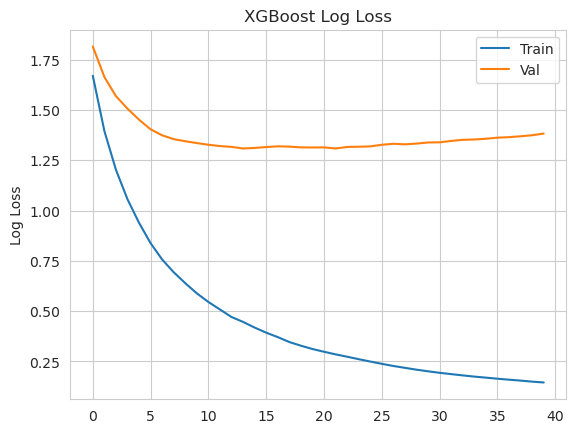

In [166]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

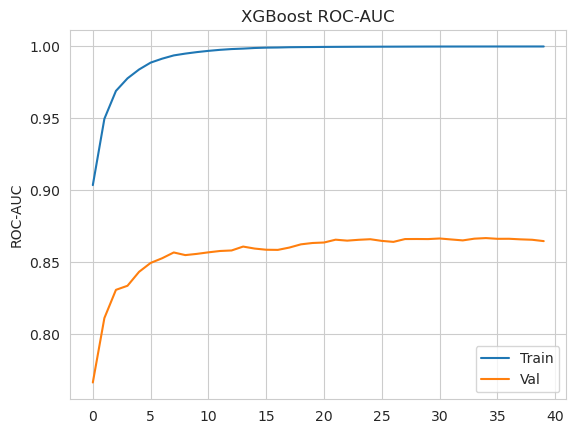

In [167]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Val')
ax.legend()
plt.ylabel('ROC-AUC')
plt.title('XGBoost ROC-AUC')
plt.show()

In [169]:
metrics_for_model(xgb_cl, X_val_tfidf, y_val, 'TF-IDF + XGB', '1min 9s (GPU)')

F1-macro: 0.5369352169273929
ROC AUC: 0.7299151853845551
Accuracy: 0.5662251655629139


<h2 id="6_8">6.8 <span style='color:#001B94'>|</span> CatBoost</h2>

* [К оглавлению](#0)

<p class="comment" id="6_8"></p>

<p class="comment" id="6_8.1">
    <b>CatBoost</b> — это библиотека градиентного бустинга с открытым исходным      кодом, разработанная Яндексом. Это быстрая, масштабируемая и высокопроизводительная библиотека, которую можно использовать для ранжирования, классификации, регрессии и других задач машинного обучения.
</p>
    
<p class="comment" id="6_8.2">
    На вход <i>CatBoostClassifier</i> получает объект класса <i>Pool</i> из библитеки <b>catboost</b>. Изначально попробуем передать векторизованные с помощью <i>CountVectorizer</i> и <i>TF-IDF</i> данные, затем попробуем использовать встроенную векторизацию.

</p>

In [16]:
from catboost import CatBoostClassifier
from catboost import Pool

In [285]:
X_train_cv = cv_best_params.fit_transform(X_train).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()

train_pool_cv = Pool(X_train_cv,
                    label=y_train.astype(int))

val_pool_cv = Pool(X_val_cv,
                    label=y_val.astype(int))

In [286]:
cat_clf_cv = CatBoostClassifier(
        task_type='GPU',
        iterations=4000,
        eval_metric='TotalF1:average=Macro',
        early_stopping_rounds=300,
        bootstrap_type='Bernoulli'
)

cat_clf_cv.fit(
    train_pool_cv,
    verbose=100, 
    eval_set=(val_pool_cv)
)

Learning rate set to 0.058462
0:	learn: 0.3693523	test: 0.3292770	best: 0.3292770 (0)	total: 95.2ms	remaining: 6m 20s
100:	learn: 0.6777934	test: 0.5137988	best: 0.5207987 (96)	total: 4.73s	remaining: 3m 2s
200:	learn: 0.7513017	test: 0.5246850	best: 0.5284756 (187)	total: 8.66s	remaining: 2m 43s
300:	learn: 0.7997611	test: 0.5525262	best: 0.5578346 (292)	total: 12.6s	remaining: 2m 34s
400:	learn: 0.8432491	test: 0.5498609	best: 0.5578346 (292)	total: 16.4s	remaining: 2m 27s
500:	learn: 0.8700296	test: 0.5487540	best: 0.5578346 (292)	total: 20.1s	remaining: 2m 20s
600:	learn: 0.8945402	test: 0.5600899	best: 0.5637178 (594)	total: 23.9s	remaining: 2m 15s
700:	learn: 0.9147500	test: 0.5516569	best: 0.5684963 (625)	total: 28.4s	remaining: 2m 13s
800:	learn: 0.9248606	test: 0.5517096	best: 0.5684963 (625)	total: 32.5s	remaining: 2m 9s
900:	learn: 0.9305072	test: 0.5696874	best: 0.5696874 (892)	total: 36s	remaining: 2m 3s
1000:	learn: 0.9347837	test: 0.5610910	best: 0.5710431 (953)	total: 3

In [175]:
metrics_for_model(cat_clf_cv, val_pool_cv, y_val, 'CV + CatBoost', '46.8s (GPU)')

F1-macro: 0.5710430663351984
ROC AUC: 0.7450717471940004
Accuracy: 0.5794701986754967


---
<p class="comment" id="6_7.5"> Теперь попробуем в связке с <i>TF-IDF</i>. </p>

In [198]:
X_train_tfidf = tfidf_best_params.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_best_params.transform(X_val).toarray()

train_pool_tfidf = Pool(X_train_tfidf,
                    label=y_train.astype(int))

val_pool_tfidf = Pool(X_val_tfidf,
                    label=y_val.astype(int))

In [199]:
model = CatBoostClassifier(
        task_type='GPU',
        iterations=4000,
        eval_metric='TotalF1:average=Macro',
        early_stopping_rounds=300,
        bootstrap_type='Bernoulli'
)

model.fit(
    train_pool_tfidf,
    verbose=100, 
    eval_set=(val_pool_tfidf)
)

Learning rate set to 0.058462
0:	learn: 0.3712555	test: 0.3275106	best: 0.3275106 (0)	total: 176ms	remaining: 11m 42s
100:	learn: 0.7039703	test: 0.4900577	best: 0.5033735 (64)	total: 9.04s	remaining: 5m 48s
200:	learn: 0.7867869	test: 0.5236915	best: 0.5270871 (193)	total: 17.8s	remaining: 5m 36s
300:	learn: 0.8384781	test: 0.5513108	best: 0.5626231 (265)	total: 25.2s	remaining: 5m 9s
400:	learn: 0.8713336	test: 0.5596005	best: 0.5630840 (371)	total: 33.2s	remaining: 4m 58s
500:	learn: 0.8935449	test: 0.5588345	best: 0.5630840 (371)	total: 41s	remaining: 4m 46s
600:	learn: 0.9184997	test: 0.5583432	best: 0.5630840 (371)	total: 48.7s	remaining: 4m 35s
700:	learn: 0.9338815	test: 0.5512989	best: 0.5653065 (672)	total: 56.1s	remaining: 4m 23s
800:	learn: 0.9446033	test: 0.5571541	best: 0.5669021 (771)	total: 1m 3s	remaining: 4m 12s
900:	learn: 0.9501777	test: 0.5548027	best: 0.5669021 (771)	total: 1m 10s	remaining: 4m 1s
1000:	learn: 0.9544684	test: 0.5575210	best: 0.5669021 (771)	total:

In [202]:
metrics_for_model(model, val_pool_tfidf, y_val, 'TF-IDF + CatBoost', '1m 18s (GPU)')

F1-macro: 0.5669020567304881
ROC AUC: 0.7469198515907568
Accuracy: 0.5927152317880795


<p class="comment" id="6_7.3">
    Теперь попробуем создать новые <i>пулы</i>, передав предобработанный текст и указав нужную колонку датафрейма в параметре <i>text_features</i>.
</p>

In [204]:
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)

train_pool = Pool(X_train_df,
                    text_features=['text'],
                    label=y_train.astype(int))

val_pool = Pool(X_val_df,
                    text_features=['text'],
                    label=y_val.astype(int))

In [205]:
model = CatBoostClassifier(
        task_type='GPU',
        iterations=2000,
        eval_metric='TotalF1:average=Macro',
        early_stopping_rounds=300,
        bootstrap_type='Bernoulli',
)

model.fit(
    train_pool,
    verbose=100, 
    eval_set=(val_pool)
)

Learning rate set to 0.079145
0:	learn: 0.3347609	test: 0.2939822	best: 0.2939822 (0)	total: 38.7ms	remaining: 1m 17s
100:	learn: 0.7014484	test: 0.5091254	best: 0.5223568 (71)	total: 2.23s	remaining: 41.9s
200:	learn: 0.8011482	test: 0.5134079	best: 0.5243479 (188)	total: 4.06s	remaining: 36.3s
300:	learn: 0.8823565	test: 0.5255068	best: 0.5286771 (297)	total: 6.66s	remaining: 37.6s
400:	learn: 0.9240804	test: 0.5323946	best: 0.5411311 (388)	total: 8.46s	remaining: 33.7s
500:	learn: 0.9515195	test: 0.5276325	best: 0.5420223 (492)	total: 9.98s	remaining: 29.9s
600:	learn: 0.9631645	test: 0.5288567	best: 0.5420223 (492)	total: 11.5s	remaining: 26.8s
700:	learn: 0.9749752	test: 0.5286692	best: 0.5420223 (492)	total: 13s	remaining: 24.1s
bestTest = 0.5420222555
bestIteration = 492
Shrink model to first 493 iterations.


In [207]:
metrics_for_model(model, val_pool, y_val, 'CatBoost text feat', '13s (GPU)')

F1-macro: 0.5420222555373067
ROC AUC: 0.735446362559077
Accuracy: 0.5596026490066225


<h2 id="6_9">6.9 <span style='color:#001B94'>|</span> RuBERT</h2>

* [К оглавлению](#0)

<p class="comment" id="6_9"></p>

<p class="comment" id="6_9.1">
    <b>RuBERT</b> — это русскоязычная модель, обученная на большом наборе данных текста и кода. Это языковая модель, похожая на BERT, но адаптированная для русского языка.
Загрузим модель классификации текста из библиотеки Hugging Face. Модель представляет собой предварительно обученную языковую модель на большом корпусе текстов. Создадим новый слой классификатора для модели. Слой классификатора отвечает за прогнозирование класса данного входного текста.</p>

<p class="comment" id="6_9.2">Воспользуемся сервисом <i>Weights&Biases</i> 
для отслеживания процесса обучения.
</p>

In [213]:
import os
import gc
import io
import wandb

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [214]:
from kaggle_secrets import UserSecretsClient
secret_label = "wandb-key"
key = UserSecretsClient().get_secret(secret_label)
wandb.login(key=key)
wandb.init(project='course-work')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: whiteroseraf (whiterose). Use `wandb login --relogin` to force relogin


<p class="comment" id="6_9.3">Зафиксируем <i>seed</i>. Установив случайное начальное число, мы можем гарантировать, что при каждом запуске кода будет генерироваться одна и та же последовательность случайных чисел.</p>

In [5]:
import os 
import random
import numpy as np
import torch

def seedBasic(seed=None):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedTorch(seed=None):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [218]:
seedBasic(42)
seedTorch(42)

<p class="comment" id="6_9.4">Создадим класс для удобной работы с датасетом.</p>

In [219]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [220]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.values.tolist()
        self.labels = labels.values.tolist()
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return text, label

<p class="comment" id="6_9.5">Также создадим класс конфигурации модели с константами для удобства.
    
- num_classes: количество классов, на которые была произведена классификация текстов.
- batch_size: количество текстов, обрабатываемых сетью за один проход (итерацию) обучения.
- lr: скорость обучения (learning rate) - величина, определяющая, насколько сильно изменяются веса в процессе обучения.
- validate_n_epoch: периодичность валидации модели - проверки качества модели на отложенной выборке в процессе обучения.
- total_epochs: количество эпох обучения - количество проходов по всей обучающей выборке, которое модель должна сделать в процессе обучения.
- device: тип устройства, на котором будет происходить обучение (GPU или CPU).
</p>

In [6]:
class CFG:
    num_classes = 8
    batch_size = 16
    lr = 2e-5
    validate_n_epoch = 1
    total_epochs = 14
    device = "cuda" if torch.cuda.is_available() else "cpu"

In [223]:
train_dataset = TextDataset(X_train,y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = CFG.batch_size, shuffle=True, num_workers=2)

val_dataset = TextDataset(X_val,y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = CFG.batch_size, shuffle=True, num_workers=2)

In [224]:
DEVICE = CFG.device

<p class="comment" id="6_9.6">Инициализиуем модель и токенайзер из библиотеки Hugging Face. Токенайзер используется для преобразования текста в формат, понятный модели. </p>

In [225]:
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased')
model.classifier = torch.nn.Linear(768, CFG.num_classes)
model.to(DEVICE)
wandb.watch(model, log_freq=100)

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

<p class="comment" id="6_9.7">
    Объявим <i>criterion</i> - функция потерь. Это функция, которая измеряет ошибку между предсказанным выходом нейронной сети и фактическим выходом. Воспользуемся <i>CrossEntropyLoss</i>, он измеряет перекрестную энтропию между прогнозируемым выходом нейронной сети и фактическим выходом.

Зададим оптимизатор — это функция, которая обновляет параметры нейронной сети, чтобы минимизировать функцию потерь. Будем использовать <i>Adam</i> - расширение алгоритма AdaGrad. Адам использует адаптивную скорость обучения, которая рассчитывается на основе первого и второго моментов градиентов. Это помогает предотвратить слишком большую или слишком маленькую скорость обучения, что может помочь улучшить сходимость алгоритма. </p>

In [226]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)

<p class="comment" id="6_9.8">Обучим модель, рассчитывая loss и accuracity в процессе обучения.</p>

In [227]:
%%time
loss_history_train = []
loss_history_val = []

acc_train_history = []
acc_val_history = []

for epoch in tqdm(range(CFG.total_epochs)):

    model.train()
    acc = 0.0
    for x, y in (train_dataloader):
                     
        optimizer.zero_grad()

        tokenized_batch = tokenizer(x, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
        output = model(**tokenized_batch)
        preds = output["logits"]

        loss = criterion(preds, y.to(DEVICE))
        loss_history_train.append(loss.item())
        wandb.log({"loss_train": loss.item()})

        loss.backward()
        optimizer.step()
        
        acc += ((torch.argmax(torch.nn.functional.softmax(preds,dim=1),dim=1).detach().cpu()) == y).sum()
        
        del x, y
        gc.collect()
        torch.cuda.empty_cache()
        
    cur_acc_train = (acc / (len(train_dataloader) * CFG.batch_size)).item()
    acc_train_history.append(cur_acc_train)
    wandb.log({"acc_train": cur_acc_train})
    
    # validate
    if (epoch % CFG.validate_n_epoch) == 0:
        acc = 0.0
        model.eval()
        for x, y in (val_dataloader):
            with torch.no_grad():
                tokenized_batch = tokenizer(x, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
                output = model(**tokenized_batch)
                preds = output["logits"]
                
                loss = criterion(preds, y.to(DEVICE))
                loss_history_val.append(loss.item())
                wandb.log({"loss_val": loss.item()})
                
                acc += ((torch.argmax(torch.nn.functional.softmax(preds,dim=1),dim=1).detach().cpu()) == y).sum()

        cur_acc_val = (acc / (len(val_dataloader) * CFG.batch_size)).item()
        acc_val_history.append(cur_acc_val)
        wandb.log({"acc_val": cur_acc_val})
        
        del x, y
        gc.collect()
        torch.cuda.empty_cache()

100%|██████████| 14/14 [29:46<00:00, 127.59s/it]

CPU times: user 22min 38s, sys: 6min 46s, total: 29min 25s
Wall time: 29min 46s


<p class="comment" id="6_9.9">Ниже представлены графики именения <i>loss</i> и <i>accuracity</i> на обучающей и валидационной выборке, полученные с помощью сервиса <i>Weights&Biases</i> .</p>

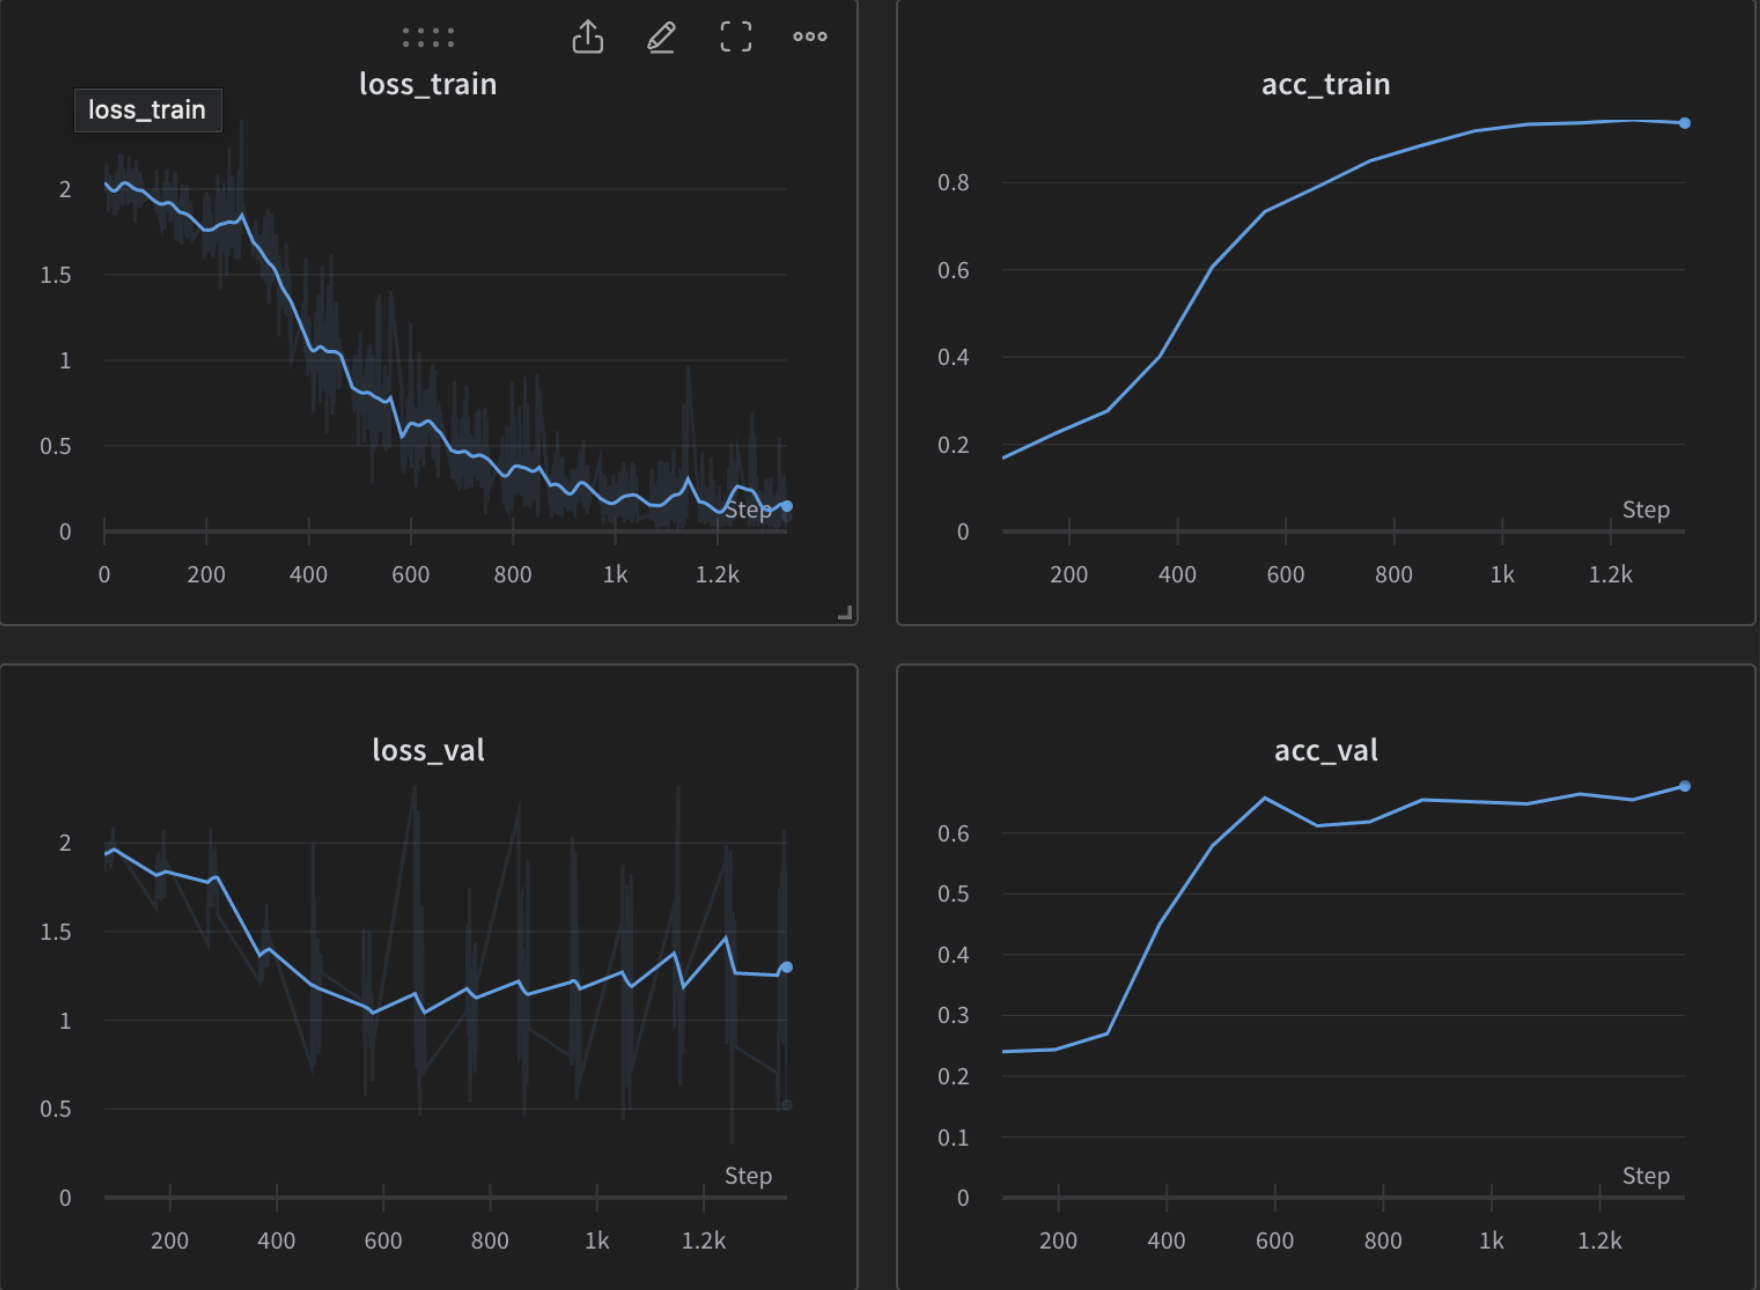

<p class="comment" id="6_9.10">Напишем функцию для рассчитывая метрик и добавления результатов в итоговую таблицу.</p>

In [237]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def metrics_for_model_rubert(model, dataloader, description=None, time=None):
    model.eval()
    preds_list = []
    targets_list = []
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            tokenized_batch = tokenizer(x, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
            output = model(**tokenized_batch)
            preds = output["logits"]
            preds_list.extend(torch.argmax(torch.nn.functional.softmax(preds,dim=1),dim=1).detach().cpu().numpy())
            targets_list.extend(y.cpu().numpy())
    roc_auc = roc_auc_score(np.eye(8)[targets_list], np.eye(8)[preds_list])
    f1_macro = f1_score(targets_list, preds_list, average='macro')
    accuracy = accuracy_score(targets_list, preds_list)
    print(f"F1-macro: {f1_macro}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Accuracy: {accuracy}")
    if description and description not in results_df['Description'].values:
        results_df.loc[len(results_df)] = [description, f1_macro, roc_auc, accuracy, time]

In [240]:
metrics_for_model_rubert(model, val_dataloader, 'RuBERT', '29min 46s (GPU)')

100%|██████████| 19/19 [00:06<00:00,  3.08it/s]


F1-macro: 0.6434089319084071
ROC AUC: 0.7957273274011821
Accuracy: 0.6821192052980133


<h2 id="7">7 <span style='color:#001B94'>|</span> Сравнение результатов и выбор лучших моделей</h2>

* [К оглавлению](#0)

<p class="comment" id="7"></p>

<p class="comment" id="7.1">Выведем таблицу качества моделей.</p>



In [245]:
results_df

,Description,F1-macro,ROC-AUC,Acc,time
0,def CV + LogReg,0.467427,0.687167,0.476821,12.7 s
1,CV + LogReg,0.473828,0.694448,0.493377,2min 21s
2,def TF-IDF + LogReg,0.472901,0.686695,0.470199,7.07 s
3,TF-IDF + LogReg,0.478798,0.695040,0.490066,1min 5s
4,def CV + NB,0.425847,0.667166,0.420530,0.4s
5,CV + NB,0.426931,0.662754,0.423841,0.7s
6,def TF-IDF + NB,0.409496,0.660086,0.403974,0.3s
7,TF-IDF + NB,0.432916,0.668579,0.433775,1.89s
8,CV + SVC,0.460268,0.688399,0.480132,29.1s
9,TF-IDF + SVC,0.463783,0.688934,0.476821,50s


<p class="comment" id="7.2">Наилучший результат показывает самая сложная модель - предобученный <i>RuBERT</i>, но при этом ее обучение занимает больше всего времени. Также хорошие результаты показали модели <i>CatBoost</i> и <i>XGBoost</i> в связке с <i>CountVectorizer</i>, которые требуют гораздо меньше времени на обучение (при использовании GPU).</p>

<p class="comment" id="7.3">Проведем оценки этих моделей на тестовой выборке.</p>

In [270]:
test_dataset = TextDataset(X_test,y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = CFG.batch_size, shuffle=True, num_workers=2)

In [271]:
metrics_for_model_rubert(model, test_dataloader)

100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


F1-macro: 0.6649825466144745
ROC AUC: 0.8085817787272074
Accuracy: 0.6790450928381963


<p class="comment" id="7.4">Модель <i>RuBERT</i> показывает на тестовой выборке немного лучший результат, по сравнению с валидацинной выборкой, это говорит о том, что модель показывает хорошую производительность на неизвестных данных.


Выведем <i>classification report</i> - это отчет о метриках качества классификации для каждого класса в задаче многоклассовой классификации. Он содержит информацию о <i>precision</i>, <i>recall</i>, F1-мере и количестве объектов каждого класса.</p>

In [299]:
from sklearn.metrics import classification_report

def predict(model, dataloader):
    model.eval()
    preds_list = []
    targets_list = []
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            tokenized_batch = tokenizer(x, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
            output = model(**tokenized_batch)
            preds = output["logits"]
            preds_list.extend(torch.argmax(torch.nn.functional.softmax(preds,dim=1),dim=1).detach().cpu().numpy())
            targets_list.extend(y.cpu().numpy())
    return preds_list, targets_list

y_pred, y_true = predict(model, test_dataloader)
print(classification_report(y_true, y_pred))

100%|██████████| 24/24 [00:08<00:00,  2.99it/s]

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        59
           1       0.66      0.80      0.73        51
           2       0.79      0.62      0.69        53
           3       0.69      0.67      0.68        72
           4       0.54      0.67      0.60        52
           5       0.63      0.54      0.58        48
           6       0.60      0.60      0.60        25
           7       0.62      0.59      0.61        17

    accuracy                           0.68       377
   macro avg       0.67      0.66      0.66       377
weighted avg       0.69      0.68      0.68       377



<p class="comment" id="7.5">Можно заметить, что лучше всего модель идентицифицрует нулевой класс (до 250 тыс руб), первый, второй и третий немного хуже, остальные примерно на одном уровне, это говорит о том, что модель может достаточно точно определять каждый из классов. Такой результат является хорошим, так как все классы имеют одинаковую важность.</p>

<p class="comment" id="7.6">Теперь векторизуем тестовую выборку и оценим модели <i>XGBoost</i> и <i>CatBoost</i>.</p>

In [282]:
cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)
cv_best_params.fit(X_train)
X_test_cv = cv_best_params.transform(X_test).toarray()

In [283]:
metrics_for_model(xgb_cl_cv, X_test_cv, y_test)

F1-macro: 0.641130944088859
ROC AUC: 0.7908414100785813
Accuracy: 0.6419098143236074


In [287]:
metrics_for_model(cat_clf_cv, X_test_cv, y_test)

F1-macro: 0.6384251903628245
ROC AUC: 0.7885937117191311
Accuracy: 0.6419098143236074


<p class="comment" id="7.7"><i>XGBoost</i> и <i>CatBoost</i> тоже показали результаты лучше, чем на валидационной выборке, но все еще хуже, чем <i>RuBERT</i>.</p>


<p class="comment" id="7.8">
    Исходя из полученных результатов, можно утверждать, что <b>RuBERT</b> демонстрирует наилучшие и наиболее стабильные показатели по всем метрикам. Близость результатов на валидационной и тестовой выборках свидетельствует о высокой обобщающей способности данной модели. Однако, необходимо отметить, что очень долгое время обучения (~30 минут на GPU) является ее недостатком.

В то же время, модели <i>XGBoost</i> и <i>CatBoost</i> в сочетании с <i>CountVectorizer</i> демонстрируют результаты, не сильно уступающие <i>RuBERT</i>, при этом время обучения этих моделей значительно меньше (~1 минуты на GPU). Значит если длительное время обучения <i>RuBERT</i> является неприемлемым, то <b>XGBoost</b> и <b>CatBoost</b> могут быть отличным выбором.
</p>

<h2 id="8">8 <span style='color:#001B94'>|</span> How to improve: Решение проблемы дизбаланса классов </h2>

* [К оглавлению](#0)

<p class="comment" id="8"></p>

<p class="comment" id="8.1">
    Дизбаланс классов - часто встречающаяся проблема в машинном обучении. Она может привести к проблемам в процессе обучения и оценки моделей машинного обучения. Некорректное моделирование таких задач может привести к несбалансированным результатам, где модель будет сосредоточена на предсказании преобладающего класса и игнорировать редкий класс.
    
Хотя в нашем случае, проанализировав <i>classification report</i>, мы пришли к выводу, что модель хорошо идентифицирует каждый из классов, стоит рассмотреть несколько методов, решающих проблему дизбаланса.
</p>    

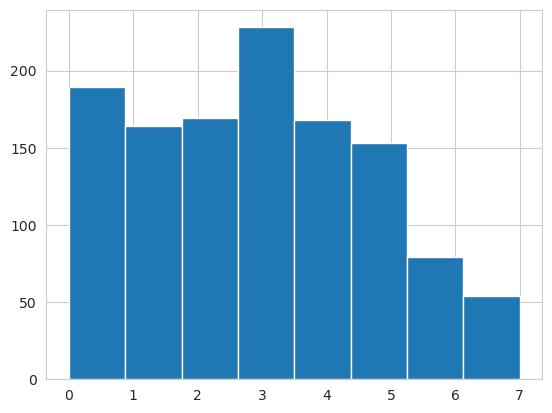

In [8]:
plt.hist(y_train, bins=8)
plt.show()

<p class="comment" id="8.2">
    Первый метод, который мы рассмотрим: <b>Объединение классов с малым количеством представителей</b>. Заново разделим наши данные, объеденив два последних классов, таким образом распределение классов приблизится к равномерному, и мы избавимся от явного дизбаланса.
</p>    

In [9]:
from sklearn.model_selection import train_test_split

def get_price_class(price):
    if price < 250000:
        return 0
    elif price < 500000:
        return 1
    elif price < 1000000:
        return 2
    elif price < 3000000:
        return 3
    elif price < 10000000:
        return 4
    elif price < 50000000:
        return 5
    else:
        return 6

data['price_class_merged'] = data['price'].apply(get_price_class)

In [10]:
X_new, y_new = data['text'], data['price_class_merged']
X_train_val_new, X_test_new, y_train_val_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42,  stratify=y)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_val_new, y_train_val_new, test_size=0.2, random_state=42,  stratify=y_train_val)

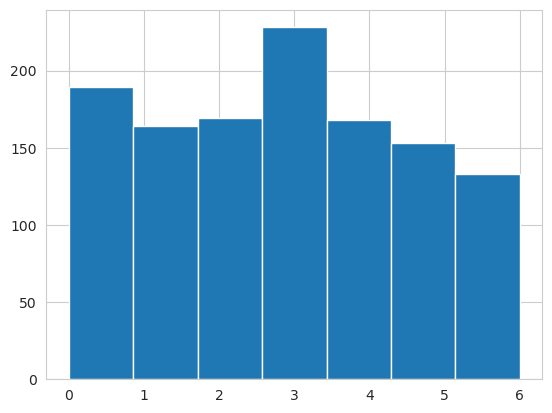

In [11]:
plt.hist(y_train_new, bins=7)
plt.show()

<p class="comment" id="8.3">
    Перестроим модель <i>CatBoost</i> и проанализируем новые результаты.
</p>    

In [15]:
cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)

X_train_cv = cv_best_params.fit_transform(X_train_new).toarray()
X_val_cv = cv_best_params.transform(X_val_new).toarray()
X_test_cv = cv_best_params.transform(X_test_new).toarray()

In [16]:
train_pool_cv = Pool(X_train_cv,
                    label=y_train_new.astype(int))
val_pool_cv = Pool(X_val_cv,
                    label=y_val_new.astype(int))
test_pool_cv = Pool(X_test_cv,
                    label=y_test_new.astype(int))

In [17]:
cat_clf_cv = CatBoostClassifier(
        task_type='GPU',
        iterations=4000,
        eval_metric='TotalF1:average=Macro',
        early_stopping_rounds=300,
        bootstrap_type='Bernoulli'
)

cat_clf_cv.fit(
    train_pool_cv,
    verbose=100, 
    eval_set=(val_pool_cv)
)

Learning rate set to 0.058462
0:	learn: 0.4105567	test: 0.3899121	best: 0.3899121 (0)	total: 82.4ms	remaining: 5m 29s
100:	learn: 0.6954169	test: 0.5220419	best: 0.5342655 (94)	total: 4.8s	remaining: 3m 5s
200:	learn: 0.7728242	test: 0.5428589	best: 0.5461134 (195)	total: 8.33s	remaining: 2m 37s
300:	learn: 0.8252262	test: 0.5429739	best: 0.5523655 (253)	total: 11.8s	remaining: 2m 24s
400:	learn: 0.8642622	test: 0.5437248	best: 0.5528984 (368)	total: 15.2s	remaining: 2m 16s
500:	learn: 0.8834056	test: 0.5530438	best: 0.5594499 (479)	total: 18.7s	remaining: 2m 10s
600:	learn: 0.9021488	test: 0.5572330	best: 0.5642543 (573)	total: 22.7s	remaining: 2m 8s
700:	learn: 0.9208327	test: 0.5786256	best: 0.5789177 (698)	total: 26.3s	remaining: 2m 3s
800:	learn: 0.9287633	test: 0.5861024	best: 0.5919536 (732)	total: 29.6s	remaining: 1m 58s
900:	learn: 0.9354888	test: 0.5920249	best: 0.5955654 (842)	total: 32.9s	remaining: 1m 53s
1000:	learn: 0.9394470	test: 0.5902935	best: 0.5974358 (931)	total: 

In [18]:
metrics_for_model(cat_clf_cv, test_pool_cv, y_test_new)

F1-macro: 0.6523237120012079
ROC AUC: 0.7992301270614834
Accuracy: 0.6604774535809018


In [19]:
from sklearn.metrics import classification_report

y_pred = cat_clf_cv.predict(X_test_cv)
y_true = y_test_new
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        59
           1       0.71      0.82      0.76        51
           2       0.62      0.62      0.62        53
           3       0.73      0.71      0.72        72
           4       0.55      0.62      0.58        52
           5       0.54      0.44      0.48        48
           6       0.67      0.67      0.67        42

    accuracy                           0.66       377
   macro avg       0.65      0.66      0.65       377
weighted avg       0.66      0.66      0.66       377



<p class="comment" id="8.4">
После объединения двух самых малочисленных классов, можно наблюдать небольшое улучшение производительности, но в тоже время, построив <i>classification report</i> можно заметить, что модель стала хуже идентифицировать класс 5.
</p>    

<p class="comment" id="8.5">
    Следующим шагом будет представлен еще один метод решения проблемы дизбаланса классов: <b>Использование взвешенных функций потерь</b>, который заключается в взвешивании функции потерь таким образом, чтобы ошибка на редком классе имела больший вес и модель уделяла ему больше внимания.
    
</p>    

In [22]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, weights))

In [23]:
cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)

X_train_cv = cv_best_params.fit_transform(X_train).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()
X_test_cv = cv_best_params.transform(X_test).toarray()

train_pool_cv = Pool(X_train_cv,
                    label=y_train.astype(int))
val_pool_cv = Pool(X_val_cv,
                    label=y_val.astype(int))
test_pool_cv = Pool(X_test_cv,
                    label=y_test.astype(int))

cat_clf_cv = CatBoostClassifier(
        task_type='GPU',
        iterations=4000,
        eval_metric='TotalF1:average=Macro',
        early_stopping_rounds=300,
        bootstrap_type='Bernoulli',
        loss_function='MultiClassOneVsAll',
        class_weights=class_weights
)

cat_clf_cv.fit(
    train_pool_cv,
    verbose=100, 
    eval_set=(val_pool_cv)
)

0:	learn: 0.3803416	test: 0.3000940	best: 0.3000940 (0)	total: 63.1ms	remaining: 4m 12s
100:	learn: 0.6141356	test: 0.4533568	best: 0.4803880 (56)	total: 5.52s	remaining: 3m 33s
200:	learn: 0.6760415	test: 0.4683970	best: 0.4803880 (56)	total: 10s	remaining: 3m 9s
300:	learn: 0.7126079	test: 0.4814205	best: 0.4894913 (293)	total: 14.8s	remaining: 3m 1s
400:	learn: 0.7668729	test: 0.5068425	best: 0.5076761 (385)	total: 19.2s	remaining: 2m 52s
500:	learn: 0.7920682	test: 0.5108509	best: 0.5140207 (451)	total: 23.4s	remaining: 2m 43s
600:	learn: 0.8057120	test: 0.5221019	best: 0.5241629 (582)	total: 27.5s	remaining: 2m 35s
700:	learn: 0.8276894	test: 0.5321049	best: 0.5334180 (688)	total: 31.5s	remaining: 2m 28s
800:	learn: 0.8422416	test: 0.5394279	best: 0.5454004 (778)	total: 35.7s	remaining: 2m 22s
900:	learn: 0.8535874	test: 0.5376170	best: 0.5454004 (778)	total: 39.6s	remaining: 2m 16s
1000:	learn: 0.8652923	test: 0.5393357	best: 0.5483928 (941)	total: 44s	remaining: 2m 11s
1100:	lea

In [24]:
metrics_for_model(cat_clf_cv, test_pool_cv, y_test)

F1-macro: 0.6210654017739002
ROC AUC: 0.7861230643324939
Accuracy: 0.6259946949602122


In [25]:
from sklearn.metrics import classification_report

y_pred = cat_clf_cv.predict(X_test_cv)
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.59      0.67        59
           1       0.62      0.80      0.70        51
           2       0.61      0.64      0.62        53
           3       0.81      0.61      0.70        72
           4       0.48      0.65      0.55        52
           5       0.51      0.44      0.47        48
           6       0.61      0.68      0.64        25
           7       0.62      0.59      0.61        17

    accuracy                           0.63       377
   macro avg       0.63      0.63      0.62       377
weighted avg       0.65      0.63      0.63       377



<p class="comment" id="8.6">
    Получили небольшое ухудшение метрик, особенно это заметно при предсказании 5 класса.
</p>

<p class="comment" id="8.7">
    <b>Аугментация данных</b> — это метод, используемый для увеличения размера и разнообразия набора данных путем создания новых точек данных из существующих.
В NLP увеличение данных часто используется для повышения производительности моделей машинного обучения на небольших или несбалансированных наборах данных. Увеличивая размер и разнообразие набора данных, дополнение данных может помочь моделям изучить более обобщенные представления данных и избежать переобучения обучающему набору.
    
Будет использоваться метод замены синонимов: этот метод случайно заменяет слова в тексте их синонимами, для этого будет использоваться библиотека <i>nlpaug</i> и предобученная модель <i>RuBERT</i>.
</p>

In [27]:
!pip install nlpaug
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.8 MB/s eta 0:00:00a 0:00:01
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  infla

In [28]:
from collections import Counter
import nlpaug.augmenter.word as naw

class ClassBalancingTextAugmenter:
    def __init__(self, model_path='DeepPavlov/rubert-base-cased', action='substitute', device='cuda'):
        self.aug = naw.ContextualWordEmbsAug(model_path=model_path, action=action, device=device)
        
    def augment_text(self, X_train, y_train, classes_to_aug, ratio=1.3):
        """
        Augments the text in the given training set to balance the classes.
        
        Args:
        X_train: A NumPy array of text data.
        y_train: A NumPy array of labels for the text data.
        classes_to_aug: A list of strings of the classes to augment.
        ratio: A float that controls the number of augmented texts that are created.
        
        Returns:
        A NumPy array of augmented text data.
        """
        augmented_texts = []
        augmented_labels = []
        class_counts = dict(Counter(y_train))
        new_class_counts = {label:int(class_counts[label] * ratio) if label in classes_to_aug else class_counts[label] for label in class_counts}

        while class_counts != new_class_counts:
            for text, label in tqdm(zip(X_train, y_train), total=len(X_train), desc='Augmenting'):
                augmented_text = text
                if label in classes_to_aug and class_counts[label] < new_class_counts[label]:
                    augmented_text = self.aug.augment(augmented_text)[0]
                    augmented_label = label
                    augmented_texts.append(augmented_text)
                    augmented_labels.append(label)
                    class_counts[augmented_label] += 1

                augmented_texts.append(text)
                augmented_labels.append(label)
#                 class_counts[label] += 1

        return np.array(augmented_texts), np.array(augmented_labels)

<p class="comment" id="8.8">Увеличим 6 и 7 классы в 1.7 раз.</p>

In [41]:
augmenter = ClassBalancingTextAugmenter()
X_train_augmented, y_train_augmented = augmenter.augment_text(X_train, y_train, classes_to_aug=[6, 7], ratio=1.7)

Augmenting: 100%|██████████| 1204/1204 [00:15<00:00, 79.98it/s]


<p class="comment" id="8.9">Сравним гистрограммы классов до и после аугментации.</p>

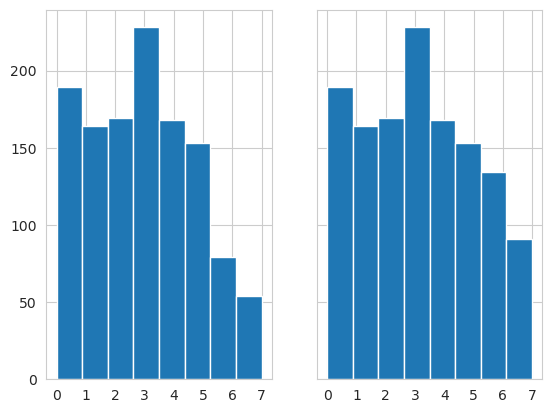

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(y_train, bins=8)
ax2.hist(y_train_augmented, bins=8)
ax1.set_xticks(range(8))
ax2.set_xticks(range(8))
plt.show()

In [48]:
cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)

X_train_cv = cv_best_params.fit_transform(X_train_augmented).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()
X_test_cv = cv_best_params.transform(X_test).toarray()

train_pool_cv = Pool(X_train_cv,
                    label=y_train_augmented.astype(int))
val_pool_cv = Pool(X_val_cv,
                    label=y_val.astype(int))
test_pool_cv = Pool(X_test_cv,
                    label=y_test.astype(int))

cat_clf_cv = CatBoostClassifier(
        task_type='GPU',
        iterations=4000,
        eval_metric='TotalF1:average=Macro',
        early_stopping_rounds=300,
        bootstrap_type='Bernoulli'
)

cat_clf_cv.fit(
    train_pool_cv,
    verbose=100, 
    eval_set=(val_pool_cv)
)

Learning rate set to 0.058898
0:	learn: 0.3449772	test: 0.2809147	best: 0.2809147 (0)	total: 81.4ms	remaining: 5m 25s
100:	learn: 0.6865120	test: 0.5130851	best: 0.5135965 (97)	total: 4.92s	remaining: 3m 10s
200:	learn: 0.7810863	test: 0.5410842	best: 0.5410842 (200)	total: 8.95s	remaining: 2m 49s
300:	learn: 0.8307969	test: 0.5336098	best: 0.5478358 (273)	total: 13.1s	remaining: 2m 40s
400:	learn: 0.8695231	test: 0.5460005	best: 0.5495197 (384)	total: 17.1s	remaining: 2m 33s
500:	learn: 0.8893887	test: 0.5519965	best: 0.5593485 (488)	total: 21s	remaining: 2m 26s
600:	learn: 0.9087616	test: 0.5529521	best: 0.5593485 (488)	total: 25s	remaining: 2m 21s
700:	learn: 0.9217727	test: 0.5636682	best: 0.5636682 (700)	total: 28.9s	remaining: 2m 15s
800:	learn: 0.9316232	test: 0.5503455	best: 0.5658890 (726)	total: 33.6s	remaining: 2m 14s
900:	learn: 0.9400222	test: 0.5537227	best: 0.5658890 (726)	total: 37.5s	remaining: 2m 8s
1000:	learn: 0.9448843	test: 0.5535520	best: 0.5658890 (726)	total: 4

In [49]:
metrics_for_model(cat_clf_cv, test_pool_cv, y_test)

F1-macro: 0.6415722733986717
ROC AUC: 0.7940331864299766
Accuracy: 0.6525198938992043


In [50]:
y_pred = cat_clf_cv.predict(X_test_cv)
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        59
           1       0.67      0.80      0.73        51
           2       0.64      0.64      0.64        53
           3       0.72      0.75      0.73        72
           4       0.52      0.62      0.57        52
           5       0.55      0.38      0.44        48
           6       0.62      0.64      0.63        25
           7       0.77      0.59      0.67        17

    accuracy                           0.65       377
   macro avg       0.65      0.64      0.64       377
weighted avg       0.65      0.65      0.65       377



<p class="comment" id="8.10">Наблюдаем небольшое улучшение метрик, но стоит заметить, что модель стала хуже идентифицировать 5 класс.

Далее аугментация будет применена ко всем классам, таким образом, мы увеличим значительно размер всей обучающей выборки.
</p>

In [51]:
augmenter = ClassBalancingTextAugmenter()
X_train_augmented, y_train_augmented = augmenter.augment_text(X_train, y_train, classes_to_aug=[1, 2, 3, 4, 5, 6, 7], ratio=1.5)

Augmenting: 100%|██████████| 1204/1204 [02:28<00:00,  8.10it/s]


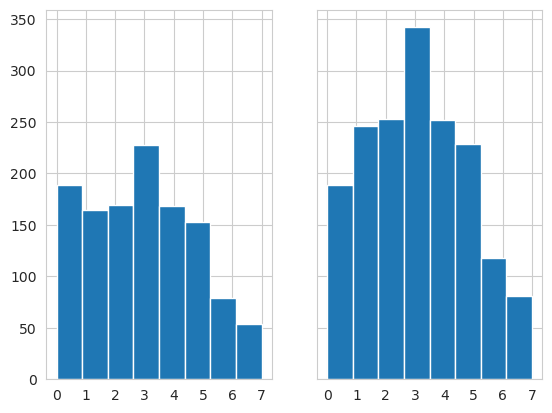

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(y_train, bins=8)
ax2.hist(y_train_augmented, bins=8)
ax1.set_xticks(range(8))
ax2.set_xticks(range(8))
plt.show()

In [53]:
cv_best_params = CountVectorizer(
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2)
)

X_train_cv = cv_best_params.fit_transform(X_train_augmented).toarray()
X_val_cv = cv_best_params.transform(X_val).toarray()
X_test_cv = cv_best_params.transform(X_test).toarray()

train_pool_cv = Pool(X_train_cv,
                    label=y_train_augmented.astype(int))
val_pool_cv = Pool(X_val_cv,
                    label=y_val.astype(int))
test_pool_cv = Pool(X_test_cv,
                    label=y_test.astype(int))

cat_clf_cv = CatBoostClassifier(
        task_type='GPU',
        iterations=4000,
        eval_metric='TotalF1:average=Macro',
        early_stopping_rounds=300,
        bootstrap_type='Bernoulli'
)

cat_clf_cv.fit(
    train_pool_cv,
    verbose=100, 
    eval_set=(val_pool_cv)
)

Learning rate set to 0.060571
0:	learn: 0.2967293	test: 0.2566759	best: 0.2566759 (0)	total: 123ms	remaining: 8m 12s
100:	learn: 0.6737108	test: 0.5169453	best: 0.5218533 (97)	total: 6.81s	remaining: 4m 22s
200:	learn: 0.7737995	test: 0.5261405	best: 0.5261405 (198)	total: 11.8s	remaining: 3m 43s
300:	learn: 0.8363886	test: 0.5439338	best: 0.5439338 (300)	total: 17.2s	remaining: 3m 30s
400:	learn: 0.8712364	test: 0.5645365	best: 0.5674012 (396)	total: 22s	remaining: 3m 17s
500:	learn: 0.8893471	test: 0.5548573	best: 0.5676551 (417)	total: 26.9s	remaining: 3m 8s
600:	learn: 0.9112083	test: 0.5632824	best: 0.5676551 (417)	total: 31.7s	remaining: 2m 59s
700:	learn: 0.9288181	test: 0.5558610	best: 0.5681320 (614)	total: 37.2s	remaining: 2m 55s
800:	learn: 0.9405193	test: 0.5645410	best: 0.5681320 (614)	total: 42.1s	remaining: 2m 48s
900:	learn: 0.9500671	test: 0.5692032	best: 0.5692998 (882)	total: 47s	remaining: 2m 41s
1000:	learn: 0.9532478	test: 0.5672007	best: 0.5703821 (941)	total: 51

In [54]:
metrics_for_model(cat_clf_cv, test_pool_cv, y_test)

F1-macro: 0.6334359608837297
ROC AUC: 0.7876772396862675
Accuracy: 0.6392572944297082


In [55]:
y_pred = cat_clf_cv.predict(X_test_cv)
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.64      0.72        59
           1       0.65      0.82      0.72        51
           2       0.62      0.62      0.62        53
           3       0.67      0.75      0.71        72
           4       0.49      0.54      0.51        52
           5       0.54      0.42      0.47        48
           6       0.64      0.64      0.64        25
           7       0.77      0.59      0.67        17

    accuracy                           0.64       377
   macro avg       0.65      0.63      0.63       377
weighted avg       0.65      0.64      0.64       377



<p class="comment" id="8.11">В итоге были проведены эксперименты с различными методами увеличения данных, результаты показали, что некоторые методы принесли улучшение в производительность моделей, а другие нет. Наиболее эффективными методами увеличения данных для моей задачи были замена синонимов на малочисленных классов.

Можно сделать вывод, что аугментация данных может быть ценным инструментом для повышения производительности моделей машинного обучения в задачах NLP. Однако важно эксперементировать с различными методами увеличения данных, чтобы найти методы, которые лучше всего подходят для конкретной задачи.</p>

<h2 id="9">9 <span style='color:#001B94'>|</span> Заключение</h2>

* [К оглавлению](#0)

<p class="comment" id="9"></p>

<p class="comment" id="9.1">
    В ходе выполнения курсовой работы была решена задача классификации текстов контрактов госзакупок по цене с использованием различных методов машинного обучения. 
Была решена задача распознавания текста с документов различных форматов, а также собраны данные о ценах государственных закупок с сайта. Были проведены этапы предобработки текстов и проведен анализ распределения цен и классов.
    
Были применены методы машинного обучения для решения задачи классификации текстов контрактов госзакупок по цене, в том числе различные методы векторизации текстов. Результаты экспериментов показали, что <i>RuBERT</i> демонстрирует наилучшие и наиболее стабильные показатели по всем метрикам, однако, длительное время обучения является ее слабым местом. Хотя модели <i>XGBoost</i> и <i>CatBoost</i> не дают наилучшие результаты по сравнению с <i>RuBERT</i>, они все же могут быть более предпочтительными в случаях, когда необходимо быстро получить результаты или когда объем обучающих данных слишком велик для использования глубоких моделей, таких как <i>RuBERT</i>.
    
В итоге можно заключить, что данная работа имеет практическую значимость для автоматизации процесса анализа контрактов госзакупок. Дальнейшее развитие исследования может быть связано с увеличением набора данных, применением более сложных моделей и улучшением качества предобработки текста, что может привести к улучшению результатов.
</p>